# Test 1

In [1]:
# Cell 0 — notebook setup (edit these paths)
import os, math, warnings
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from lsst.daf.butler import Butler
from pathlib import Path


# --- USER EDIT: set these two paths ---
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/"  # e.g. "/sdf/home/m/mrakovci/rubin-user/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation"
# If you run the notebook from the repo already, leave REPO_ROOT=None.

# Add repo to sys.path so we can import your common.py
if REPO_ROOT is not None:
    rr = Path(REPO_ROOT).resolve()
    if str(rr) not in sys.path:
        sys.path.insert(0, str(rr))

sys.path.insert(0, "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN/ADCNN/data/dataset_creation")
# Import your estimators from common.py (the functions you added)
from ADCNN.data.dataset_creation.simulate_inject import *
from common import _trail_template_for_stamp, draw_one_line

# ---- EDIT to your environment ----
DATA_DIR = "../DATA"                      # where train.h5 + train.csv live
H5_PATH  = os.path.join(DATA_DIR, "train.h5")
CSV_PATH = os.path.join(DATA_DIR, "train.csv")

REPO = "/repo/main"                       # same repo you used for injection
COLL = "LSSTComCam/runs/DRP/DP1/w_2025_17/DM-50530"  # same collections
# ----------------------------------

pd.set_option("display.max_columns", 200)
warnings.filterwarnings("ignore")

print("H5 exists:", os.path.exists(H5_PATH))
print("CSV exists:", os.path.exists(CSV_PATH))


H5 exists: True
CSV exists: True


In [2]:
# Cell 1 — load train.csv and basic sanity checks
df = pd.read_csv(CSV_PATH)
print("rows:", len(df))
print(df.columns.tolist())

# minimal columns we expect for this investigation
need = ["image_id","x","y","trail_length","beta","SNR","stack_snr","visit","detector"]
missing = [c for c in need if c not in df.columns]
print("missing:", missing)

# keep only rows where stack_snr exists (detected) and finite
d = df.copy()
d = d.replace([np.inf,-np.inf], np.nan)
d = d.dropna(subset=["image_id","x","y","trail_length","beta","SNR","stack_snr"])
d = d[(d["SNR"]>0) & (d["stack_snr"]>0)]
print("usable rows:", len(d))
d.head()


rows: 16000
['ra', 'dec', 'source_type', 'trail_length', 'mag', 'beta', 'visit', 'detector', 'integrated_mag', 'PSF_mag', 'SNR', 'physical_filter', 'x', 'y', 'stack_detection', 'stack_mag', 'stack_mag_err', 'stack_snr', 'image_id']
missing: []
usable rows: 11843


,ra,dec,source_type,trail_length,mag,beta,visit,detector,integrated_mag,PSF_mag,SNR,physical_filter,x,y,stack_detection,stack_mag,stack_mag_err,stack_snr,image_id
0,52.992813,-27.746259,Trail,56.415484,25.128170,63.144567,2024110900217,5,20.749674,21.543205,8.830449,u,3198,1141,True,22.208762,0.109018,9.959211,61
1,53.087996,-27.851596,Trail,40.274247,25.472244,55.275831,2024110900217,5,21.459675,22.113661,5.654904,u,1681,3029,True,22.847238,0.188627,5.756007,61
3,53.067700,-27.758485,Trail,22.085071,26.041493,162.710296,2024110900217,5,22.681246,23.089694,3.766061,u,3243,2350,True,22.711545,0.158855,6.834780,61
4,53.068057,-27.839778,Trail,57.008706,25.337191,164.697485,2024110900217,5,20.947338,21.761448,9.552066,u,1819,2674,True,22.698208,0.164412,6.603759,61
6,53.094019,-27.820638,Trail,58.053347,25.470512,94.754440,2024110900217,5,21.060944,21.880205,7.952871,u,2245,3002,True,22.699424,0.163581,6.637293,61


In [3]:
# Cell 2 — open H5, helper to extract a stamp around (x,y)
f = h5py.File(H5_PATH, "r")
imgs  = f["images"]
masks = f["masks"]
print("images shape:", imgs.shape, imgs.dtype)
print("masks  shape:", masks.shape, masks.dtype)

def cutout(arr2d, cx, cy, half=96):
    """Centered cutout; returns (stamp, x0, y0)."""
    H, W = arr2d.shape
    cx = int(round(cx)); cy = int(round(cy))
    x0 = max(cx-half, 0); x1 = min(cx+half+1, W)
    y0 = max(cy-half, 0); y1 = min(cy+half+1, H)
    stamp = arr2d[y0:y1, x0:x1]
    return stamp, x0, y0

def show_img_mask_row(row, half=96):
    img_id = int(row["image_id"])
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])
    snr = float(row["SNR"]); ssnr = float(row["stack_snr"])

    img = imgs[img_id].astype(np.float32)
    msk = masks[img_id].astype(bool)

    img_s, x0, y0 = cutout(img, x, y, half=half)
    msk_s, _, _   = cutout(msk, x, y, half=half)

    # mark the (x,y) inside the stamp
    mx = x - x0
    my = y - y0

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].imshow(img_s, origin="upper")
    ax[0].plot(mx, my, "x", ms=10)
    ax[0].set_title("image stamp")

    ax[1].imshow(msk_s, origin="upper")
    ax[1].plot(mx, my, "x", ms=10)
    ax[1].set_title("mask stamp")

    fig.suptitle(f"img_id={img_id}  L={L:.1f}  beta={th:.1f}  SNR={snr:.2f}  stack_snr={ssnr:.2f}\n"
                 f"(x,y)=({x:.1f},{y:.1f})", y=1.05)
    plt.tight_layout()
    plt.show()


images shape: (800, 4000, 4072) float32
masks  shape: (800, 4000, 4072) bool


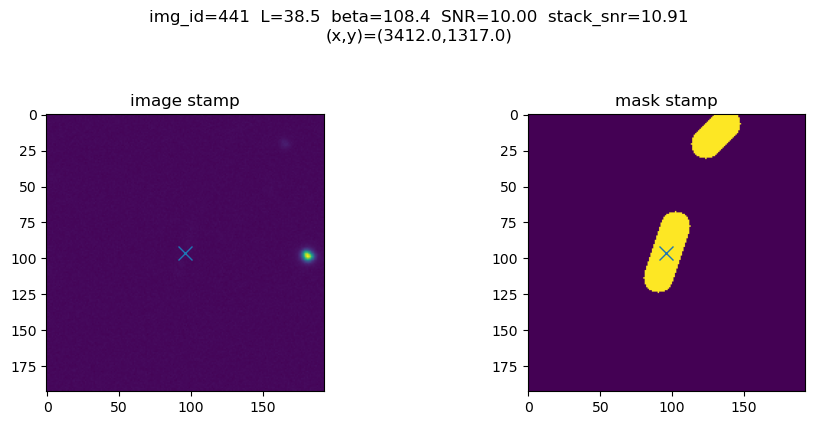

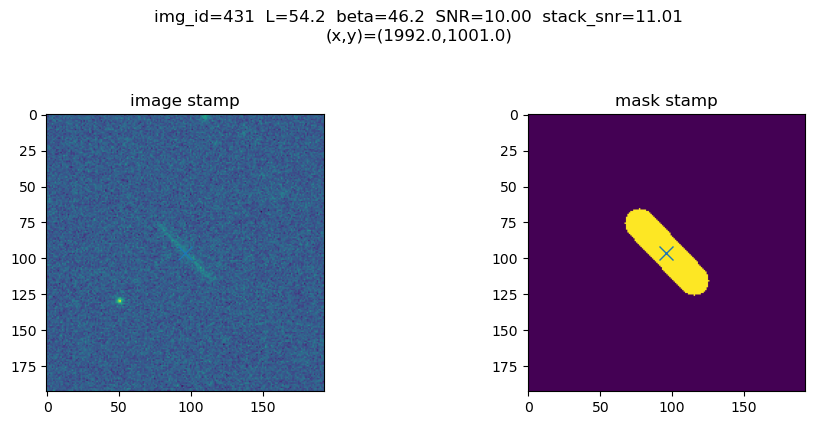

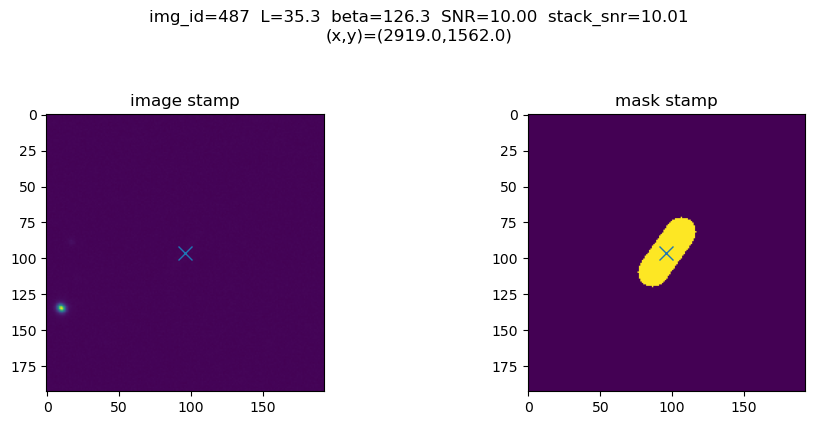

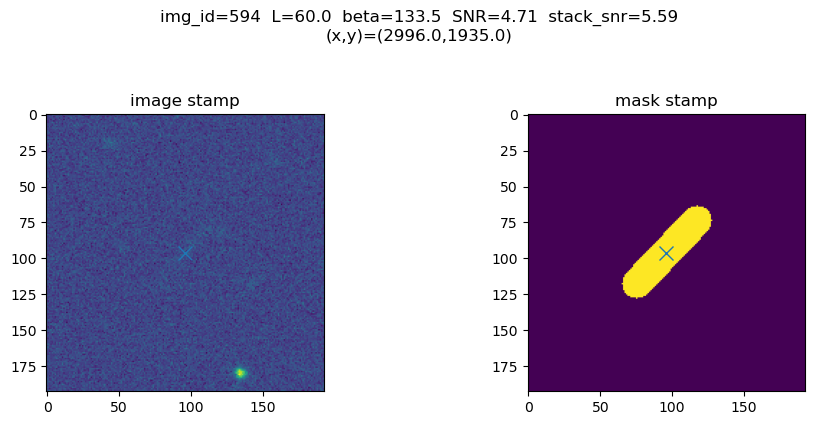

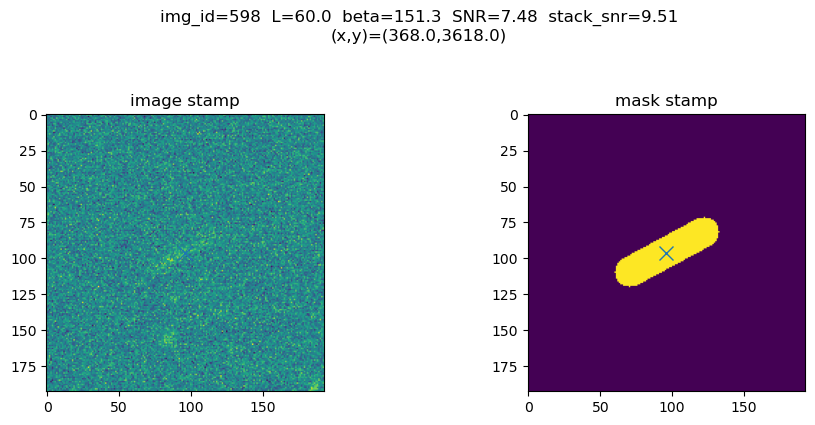

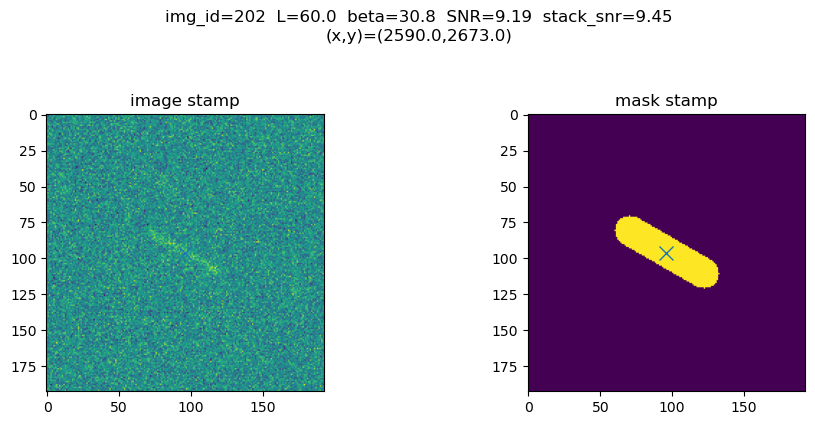

In [4]:
# Cell 3 — pick some bright/long examples and visualize (this is your “placement” check)
# pick bright-ish (high SNR) and long-ish
bright = d.sort_values("SNR", ascending=False).head(3)
long   = d.sort_values("trail_length", ascending=False).head(3)

for _, r in bright.iterrows():
    show_img_mask_row(r, half=96)

for _, r in long.iterrows():
    show_img_mask_row(r, half=96)


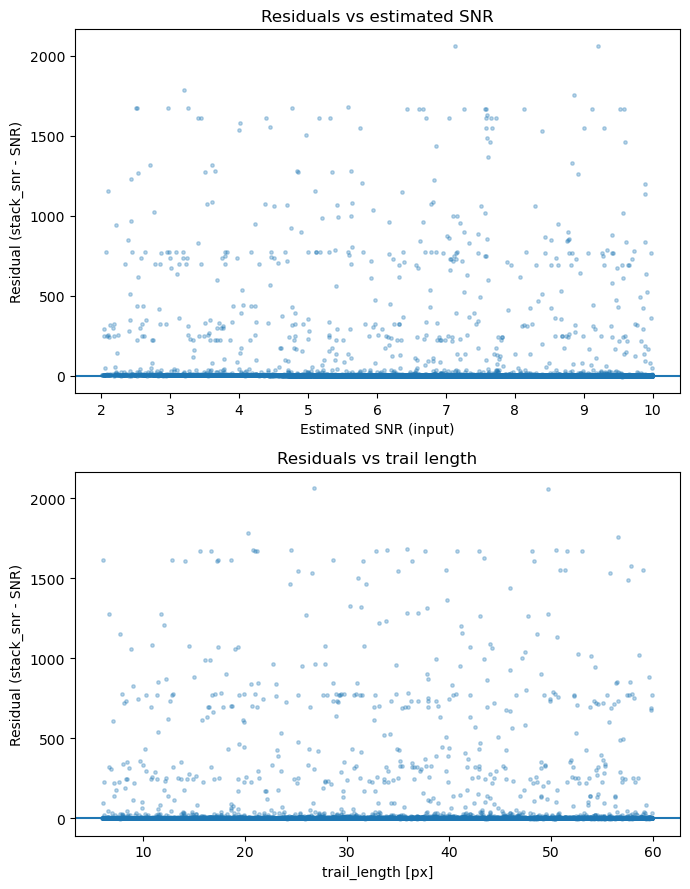

residual mean: 25.22421947817636 std: 148.8550542646831


In [5]:
# Cell 4 — residual plots (baseline diagnostics)
dd = d.copy()
dd["resid"] = dd["stack_snr"] - dd["SNR"]

fig, ax = plt.subplots(2, 1, figsize=(7,9))
ax[0].scatter(dd["SNR"], dd["resid"], s=6, alpha=0.3)
ax[0].axhline(0)
ax[0].set_xlabel("Estimated SNR (input)")
ax[0].set_ylabel("Residual (stack_snr - SNR)")
ax[0].set_title("Residuals vs estimated SNR")

ax[1].scatter(dd["trail_length"], dd["resid"], s=6, alpha=0.3)
ax[1].axhline(0)
ax[1].set_xlabel("trail_length [px]")
ax[1].set_ylabel("Residual (stack_snr - SNR)")
ax[1].set_title("Residuals vs trail length")

plt.tight_layout()
plt.show()

print("residual mean:", dd["resid"].mean(), "std:", dd["resid"].std())


In [6]:
# Cell 5 — LSST stack access (needed to compute PSF and T on the *same exposure*)
from lsst.daf.butler import Butler
import lsst.geom as geom
import cv2

butler = Butler(REPO, collections=COLL)

def get_calexp_for_row(row):
    # you may need to tweak dataset type to match your pipeline:
    # in your inject code you used: butler.get("preliminary_visit_image", dataId=ref.dataId)
    dataId = {"visit": int(row["visit"]), "detector": int(row["detector"])}
    calexp = butler.get("preliminary_visit_image", dataId=dataId)
    return calexp, dataId

def compute_psf_image(calexp, x, y, use_kernel=True):
    psf = calexp.getPsf()
    p = geom.Point2D(float(x), float(y))
    if use_kernel and hasattr(psf, "computeKernelImage"):
        return psf.computeKernelImage(p).array.astype(np.float64)
    return psf.computeImage(p).array.astype(np.float64)

def centroid_xy(img):
    H, W = img.shape
    yy, xx = np.mgrid[0:H, 0:W]
    tot = float(img.sum())
    if not np.isfinite(tot) or tot <= 0:
        return (W-1)/2.0, (H-1)/2.0
    cx = float((xx*img).sum()/tot)
    cy = float((yy*img).sum()/tot)
    return cx, cy



In [7]:
# Cell 6 — build T in TWO ways, and measure symmetry/asymmetry
def add_shift_old(acc, psf_img, dx, dy, interp=cv2.INTER_LINEAR):
    """Your old approach: warp small PSF then paste at (aw-pw)//2."""
    ph, pw = psf_img.shape
    ah, aw = acc.shape
    M = np.array([[1.0, 0.0, dx],
                  [0.0, 1.0, dy]], dtype=np.float32)
    shifted = cv2.warpAffine(psf_img.astype(np.float32), M, dsize=(pw, ph),
                             flags=interp, borderMode=cv2.BORDER_CONSTANT, borderValue=0.0).astype(np.float64)
    x0 = (aw - pw)//2
    y0 = (ah - ph)//2
    x1, y1 = x0+pw, y0+ph

    ax0, ay0 = max(x0,0), max(y0,0)
    ax1, ay1 = min(x1,aw), min(y1,ah)
    if ax0>=ax1 or ay0>=ay1:
        return
    px0, py0 = ax0-x0, ay0-y0
    px1, py1 = px0+(ax1-ax0), py0+(ay1-ay0)
    acc[ay0:ay1, ax0:ax1] += shifted[py0:py1, px0:px1]

def add_shift_centroid(acc, psf_img, dx, dy, psf_cx=None, psf_cy=None, interp=cv2.INTER_LINEAR):
    """
    Place so that PSF centroid lands at acc_center + (dx,dy),
    where acc_center is the true center ((W-1)/2, (H-1)/2).
    """
    ah, aw = acc.shape
    ph, pw = psf_img.shape
    acc_cx = (aw-1)/2.0
    acc_cy = (ah-1)/2.0
    if psf_cx is None or psf_cy is None:
        psf_cx, psf_cy = centroid_xy(psf_img)

    target_cx = acc_cx + float(dx)
    target_cy = acc_cy + float(dy)

    x0 = int(np.floor(target_cx - psf_cx))
    y0 = int(np.floor(target_cy - psf_cy))

    fx = float(target_cx - (x0 + psf_cx))
    fy = float(target_cy - (y0 + psf_cy))

    M = np.array([[1.0, 0.0, fx],
                  [0.0, 1.0, fy]], dtype=np.float32)
    shifted = cv2.warpAffine(psf_img.astype(np.float32), M, dsize=(pw, ph),
                             flags=interp, borderMode=cv2.BORDER_CONSTANT, borderValue=0.0).astype(np.float64)

    x1, y1 = x0+pw, y0+ph
    ax0, ay0 = max(x0,0), max(y0,0)
    ax1, ay1 = min(x1,aw), min(y1,ah)
    if ax0>=ax1 or ay0>=ay1:
        return
    px0, py0 = ax0-x0, ay0-y0
    px1, py1 = px0+(ax1-ax0), py0+(ay1-ay0)
    acc[ay0:ay1, ax0:ax1] += shifted[py0:py1, px0:px1]

def build_T(calexp, x, y, L_pix, theta_deg, out_shape, use_kernel=True, step=0.15, method="centroid"):
    psf = compute_psf_image(calexp, x, y, use_kernel=use_kernel)
    s = float(psf.sum())
    psf_unit = psf / s

    H, W = out_shape
    T = np.zeros((H,W), dtype=np.float64)

    th = math.radians(float(theta_deg))
    ux, uy = math.cos(th), math.sin(th)

    n = int(math.ceil(float(L_pix)/step))+1
    n = max(n, 21)
    s_vals = np.linspace(-0.5*L_pix, 0.5*L_pix, n)

    psf_cx, psf_cy = centroid_xy(psf_unit)

    for sv in s_vals:
        dx = float(sv*ux)
        dy = float(sv*uy)
        if method == "old":
            add_shift_old(T, psf_unit, dx, dy, interp=cv2.INTER_LINEAR)
        else:
            add_shift_centroid(T, psf_unit, dx, dy, psf_cx=psf_cx, psf_cy=psf_cy, interp=cv2.INTER_LINEAR)

    # clip tiny negatives from interpolation
    T[T < 0] = 0.0
    Ts = float(T.sum())
    T /= Ts
    return T, psf_unit

def stamp_center(shape):
    H, W = shape
    return (W-1)/2.0, (H-1)/2.0


In [8]:
# Cell 7 — perpendicular profile + asymmetry metric (this is what you plotted)
def perp_profile(T, theta_deg, cx, cy, halfwidth=80, band=6):
    """
    Average T in a narrow band along the trail direction, as a function of perpendicular distance.
    Returns distances d and profile p(d).
    """
    H, W = T.shape
    yy, xx = np.mgrid[0:H, 0:W]
    x = xx - cx
    y = yy - cy

    th = math.radians(theta_deg)
    ux, uy = math.cos(th), math.sin(th)
    # along and perp coordinates
    s = x*ux + y*uy
    d = -x*uy + y*ux

    # keep only pixels close to the trail axis
    m = np.abs(s) <= band

    # bin in perpendicular distance
    bins = np.arange(-halfwidth, halfwidth+1, 1.0)
    prof = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        lo, hi = bins[i], bins[i+1]
        sel = m & (d >= lo) & (d < hi)
        if np.any(sel):
            prof[i] = float(T[sel].mean())
        else:
            prof[i] = 0.0
    centers = 0.5*(bins[:-1] + bins[1:])
    return centers, prof

def max_fractional_asymmetry(x, p):
    """
    Compare p(d) and p(-d). Return max(|p(d)-p(-d)| / (p(d)+p(-d)+eps)).
    """
    eps = 1e-30
    # assume x is symmetric integer centers
    mid = len(x)//2
    amax = 0.0
    for i in range(1, mid):
        p1 = p[mid+i]
        p2 = p[mid-i]
        frac = abs(p1-p2)/(p1+p2+eps)
        if frac > amax:
            amax = frac
    return amax

def show_T_diagnostics(row, use_kernel=True, pad_sigma=5.0, R_floor=20, step=0.15, halfwidth=100, band=6):
    calexp, dataId = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])

    # pick out_shape similarly to your sigmaF code
    psf = compute_psf_image(calexp, x, y, use_kernel=use_kernel)
    psf_sum = float(psf.sum())
    psf_unit = psf/psf_sum

    # crude sigma estimate (2nd moment)
    Hs, Ws = psf_unit.shape
    yy, xx = np.mgrid[0:Hs, 0:Ws]
    cxp, cyp = centroid_xy(psf_unit)
    m2 = (((xx-cxp)**2 + (yy-cyp)**2) * psf_unit).sum()/psf_unit.sum()/2.0
    sigma_pix = math.sqrt(float(m2))
    R = max(int(math.ceil(pad_sigma*sigma_pix)), R_floor)
    S = int(math.ceil(L)) + 2*R + 1
    if S % 2 == 0: S += 1
    if S < 33: S = 33
    out_shape = (S,S)

    Told, _ = build_T(calexp, x, y, L, th, out_shape, use_kernel=use_kernel, step=step, method="old")
    Tcen, _ = build_T(calexp, x, y, L, th, out_shape, use_kernel=use_kernel, step=step, method="centroid")

    cxo, cyo = centroid_xy(Told)
    cxc, cyc = centroid_xy(Tcen)
    scx, scy = stamp_center(out_shape)

    # profiles centered on each T's own centroid
    xo, po = perp_profile(Told, th, cxo, cyo, halfwidth=halfwidth, band=band)
    xc, pc = perp_profile(Tcen, th, cxc, cyc, halfwidth=halfwidth, band=band)
    ao = max_fractional_asymmetry(xo, po)
    ac = max_fractional_asymmetry(xc, pc)

    fig, ax = plt.subplots(2, 2, figsize=(10,8))

    ax[0,0].imshow(np.log10(Told + 1e-12), origin="upper")
    ax[0,0].set_title(f"log10(T) old\ncentroid=({cxo:.2f},{cyo:.2f})  center=({scx:.2f},{scy:.2f})")

    ax[0,1].imshow(np.log10(Tcen + 1e-12), origin="upper")
    ax[0,1].set_title(f"log10(T) centroid\ncentroid=({cxc:.2f},{cyc:.2f})  center=({scx:.2f},{scy:.2f})")

    ax[1,0].plot(xo, po)
    ax[1,0].axvline(0, ls="--")
    ax[1,0].set_title(f"perp profile (old)  max frac asym={ao:.3f}")
    ax[1,0].set_xlabel("perp distance [px]"); ax[1,0].set_ylabel("mean(T)")

    ax[1,1].plot(xc, pc)
    ax[1,1].axvline(0, ls="--")
    ax[1,1].set_title(f"perp profile (centroid)  max frac asym={ac:.3f}")
    ax[1,1].set_xlabel("perp distance [px]"); ax[1,1].set_ylabel("mean(T)")

    plt.tight_layout()
    plt.show()

    print("Row:", {k: row[k] for k in ["image_id","visit","detector","x","y","trail_length","beta","SNR","stack_snr"] if k in row})
    print(f"PSF centroid in its own stamp: ({cxp:.3f},{cyp:.3f}) vs geometric center ({(Ws-1)/2:.3f},{(Hs-1)/2:.3f})")
    print(f"T old centroid offset from stamp center: dx={cxo-scx:+.3f} dy={cyo-scy:+.3f}")
    print(f"T cen centroid offset from stamp center: dx={cxc-scx:+.3f} dy={cyc-scy:+.3f}")


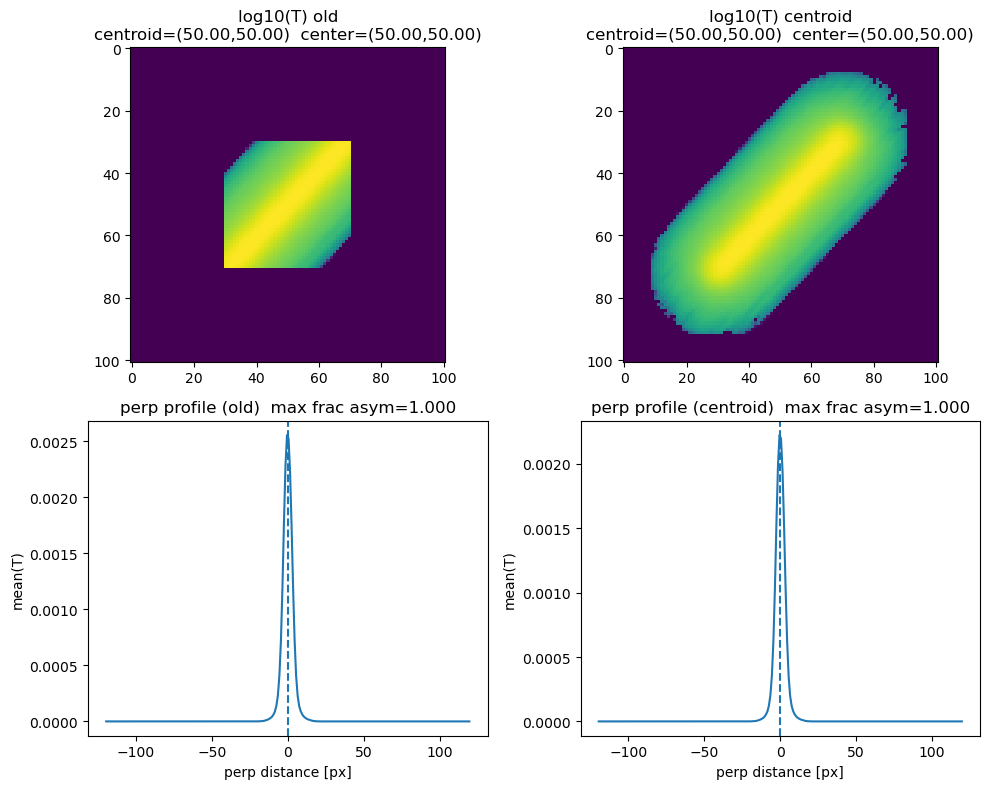

Row: {'image_id': 594, 'visit': 2024111700352, 'detector': 5, 'x': 2996, 'y': 1935, 'trail_length': 59.99519838200133, 'beta': 133.47138200792435, 'SNR': 4.711406514240656, 'stack_snr': 5.590896576426999}
PSF centroid in its own stamp: (20.009,19.980) vs geometric center (20.000,20.000)
T old centroid offset from stamp center: dx=-0.003 dy=+0.001
T cen centroid offset from stamp center: dx=-0.001 dy=-0.001


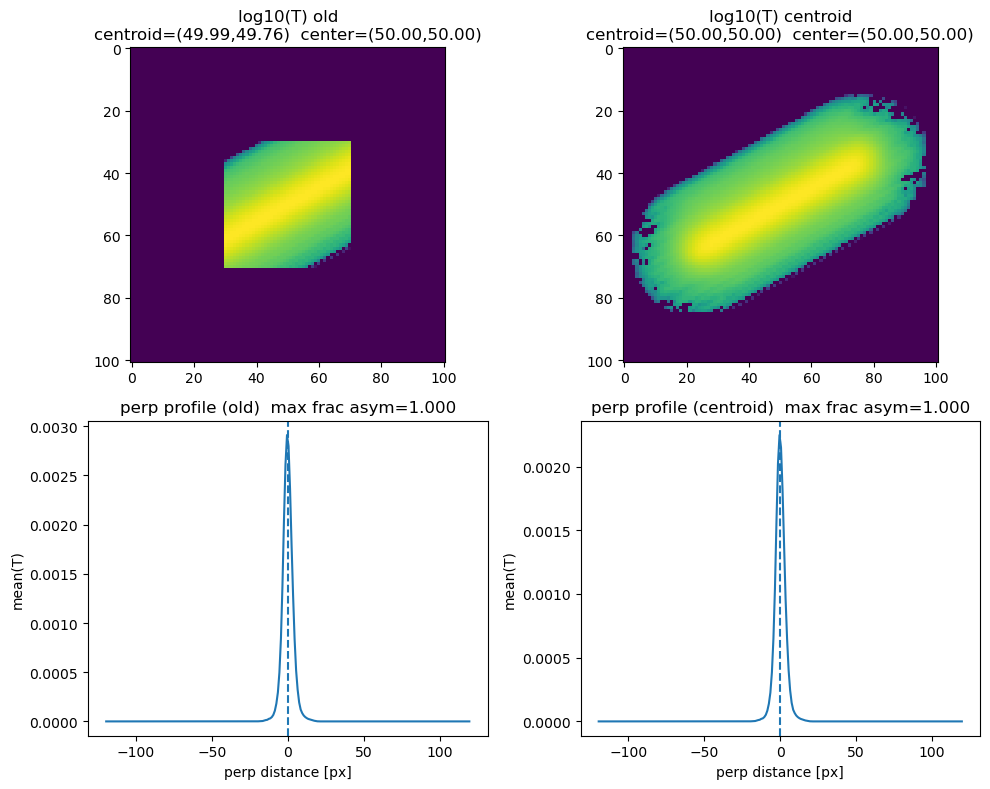

Row: {'image_id': 598, 'visit': 2024112300219, 'detector': 3, 'x': 368, 'y': 3618, 'trail_length': 59.96977284461113, 'beta': 151.32178045261048, 'SNR': 7.484074874972781, 'stack_snr': 9.507139256797773}
PSF centroid in its own stamp: (20.088,19.689) vs geometric center (20.000,20.000)
T old centroid offset from stamp center: dx=-0.012 dy=-0.241
T cen centroid offset from stamp center: dx=-0.000 dy=-0.001


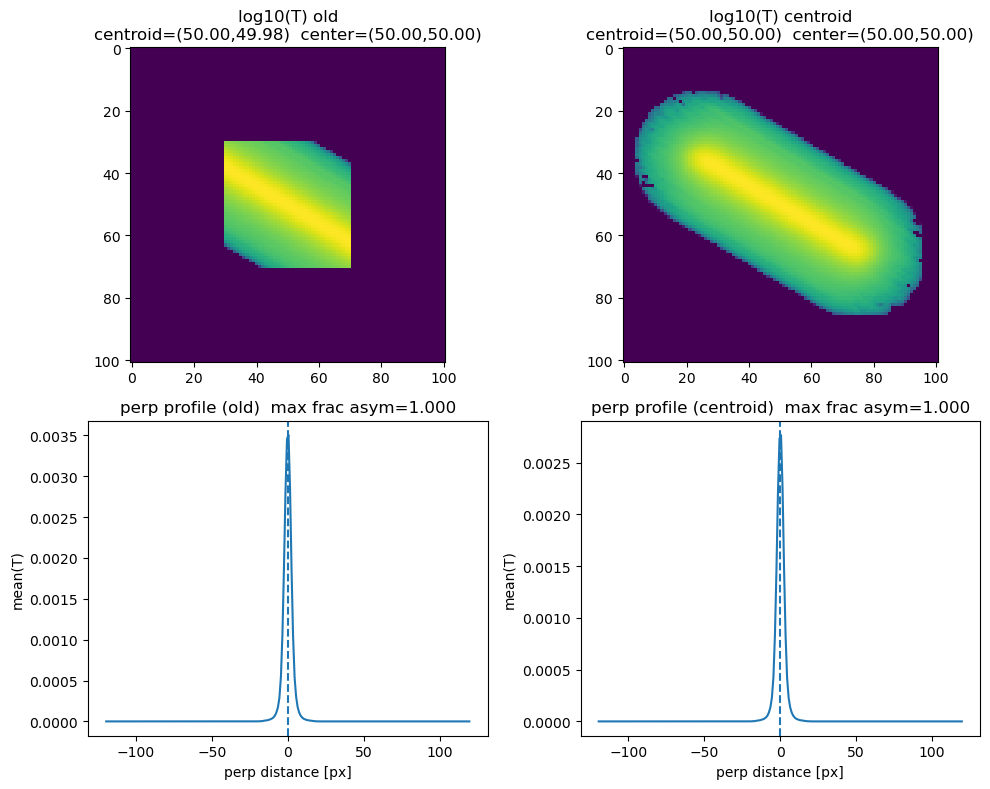

Row: {'image_id': 202, 'visit': 2024111700147, 'detector': 2, 'x': 2590, 'y': 2673, 'trail_length': 59.96335235553887, 'beta': 30.777175152492337, 'SNR': 9.185914247379774, 'stack_snr': 9.453246959128435}
PSF centroid in its own stamp: (20.090,20.033) vs geometric center (20.000,20.000)
T old centroid offset from stamp center: dx=+0.003 dy=-0.016
T cen centroid offset from stamp center: dx=-0.001 dy=-0.001


In [9]:
# Cell 8 — run T diagnostics on a few cases (pick long ones first)
samples = d.sort_values("trail_length", ascending=False).head(3)
for _, r in samples.iterrows():
    show_T_diagnostics(r, use_kernel=True, step=0.15, halfwidth=120, band=8)


 200 / 200

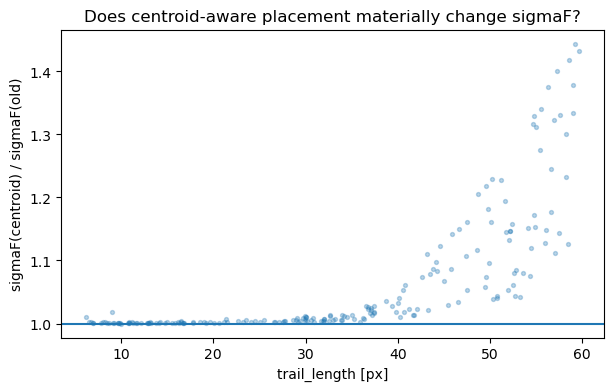

median ratio: 1.0113122106157546 p16/p84: [1.00111656 1.14718059]


In [10]:
# Cell 9 — sigmaF sensitivity study: compare "old" vs "centroid" T build
# This isolates whether your mismatch is mostly geometry/centering or something else.

def get_var_stamp(calexp, x, y, out_shape):
    var_full = calexp.variance.array.astype(np.float64)
    Himg, Wimg = var_full.shape
    H, W = out_shape
    cx = int(round(x)); cy = int(round(y))
    x0 = cx - W//2; y0 = cy - H//2
    x1 = x0 + W;    y1 = y0 + H
    v = np.full((H,W), np.nan, dtype=np.float64)
    ix0, iy0 = max(x0,0), max(y0,0)
    ix1, iy1 = min(x1,Wimg), min(y1,Himg)
    if ix0<ix1 and iy0<iy1:
        vx0, vy0 = ix0-x0, iy0-y0
        v[vx0*0:0+1] = v[vx0*0:0+1]  # no-op; keeps cell explicit
        v[vy0:vy0+(iy1-iy0), vx0:vx0+(ix1-ix0)] = var_full[iy0:iy1, ix0:ix1]
    return v

def psf_to_outshape(psf_img, out_shape):
    # center crop/pad (geometric)
    H,W = out_shape
    out = np.zeros((H,W), dtype=np.float64)
    ih, iw = psf_img.shape
    cy, cx = ih//2, iw//2
    oy, ox = H//2, W//2
    ys0 = max(0, cy-oy); xs0 = max(0, cx-ox)
    ys1 = min(ih, ys0+H); xs1 = min(iw, xs0+W)
    yd0 = max(0, oy-cy); xd0 = max(0, ox-cx)
    yd1 = yd0 + (ys1-ys0); xd1 = xd0 + (xs1-xs0)
    out[yd0:yd1, xd0:xd1] = psf_img[ys0:ys1, xs0:xs1]
    return out

def sigmaF_from_phi_T_var(phi, T, var):
    good = np.isfinite(var) & (var>0) & np.isfinite(phi) & np.isfinite(T)
    denom = np.sum((phi[good]**2)/var[good])
    ov    = np.sum((phi[good]*T[good])/var[good])
    if denom<=0 or ov<=0:
        return np.nan
    return float(np.sqrt(denom)/ov)

def compare_sigmaF(row, use_kernel=True, pad_sigma=5.0, R_floor=20, step=0.15):
    calexp, _ = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])

    psf = compute_psf_image(calexp, x, y, use_kernel=use_kernel)
    psf_unit = psf/psf.sum()

    # sigma estimate -> out_shape as in your code
    Hs, Ws = psf_unit.shape
    cxp, cyp = centroid_xy(psf_unit)
    yy, xx = np.mgrid[0:Hs, 0:Ws]
    m2 = (((xx-cxp)**2 + (yy-cyp)**2) * psf_unit).sum()/psf_unit.sum()/2.0
    sigma_pix = math.sqrt(float(m2))
    R = max(int(math.ceil(pad_sigma*sigma_pix)), R_floor)
    S = int(math.ceil(L)) + 2*R + 1
    if S%2==0: S+=1
    if S<33: S=33
    out_shape = (S,S)

    # phi on out_shape (geometric center crop/pad)
    phi = psf_to_outshape(psf_unit, out_shape)
    phi = phi / np.nansum(phi)

    var = get_var_stamp(calexp, x, y, out_shape)

    Told,_ = build_T(calexp, x, y, L, th, out_shape, use_kernel=use_kernel, step=step, method="old")
    Tcen,_ = build_T(calexp, x, y, L, th, out_shape, use_kernel=use_kernel, step=step, method="centroid")

    s_old = sigmaF_from_phi_T_var(phi, Told, var)
    s_cen = sigmaF_from_phi_T_var(phi, Tcen, var)

    return s_old, s_cen, out_shape

# run on a small batch and plot ratio vs L
batch = d.sample(n=min(200, len(d)), random_state=0)
Ls, r = [], []
counter=0
for _, row in batch.iterrows():
    counter+=1
    print (f"\r", counter, "/", len(batch), end="")
    so, sc, _ = compare_sigmaF(row, use_kernel=True, step=0.15)
    if np.isfinite(so) and np.isfinite(sc) and so>0:
        Ls.append(float(row["trail_length"]))
        r.append(sc/so)

plt.figure(figsize=(7,4))
plt.scatter(Ls, r, s=8, alpha=0.3)
plt.axhline(1)
plt.xlabel("trail_length [px]")
plt.ylabel("sigmaF(centroid) / sigmaF(old)")
plt.title("Does centroid-aware placement materially change sigmaF?")
plt.show()

print("median ratio:", np.median(r), "p16/p84:", np.percentile(r,[16,84]))


 300 / 300

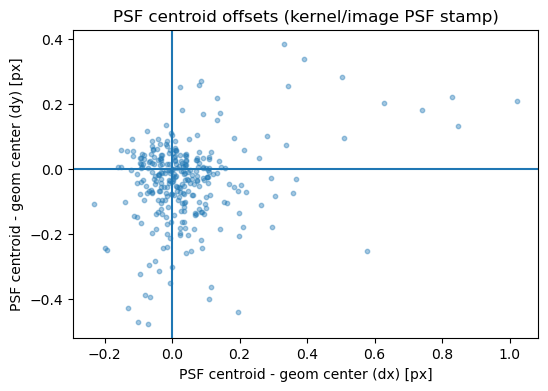

dx median: 0.012603211586869278 dy median: -0.024110959582074543
dx p16/p84: [-0.060853    0.10895089] dy p16/p84: [-0.13922993  0.05278185]


In [11]:
# Cell 10 — next culprit check: is the PSF itself asymmetric / off-centered?
# If PSF centroid is off by ~0.2–0.5 px consistently, it will leak into T unless handled.
# This cell measures PSF centroid offsets across random samples.

def psf_centroid_offsets(sample_df, n=200, use_kernel=True):
    ss = sample_df.sample(n=min(n, len(sample_df)), random_state=1)
    dxs, dys = [], []
    counter = 0
    for _, row in ss.iterrows():
        counter+=1
        print (f"\r", counter, "/", len(ss), end="")
        calexp, _ = get_calexp_for_row(row)
        x = float(row["x"]); y = float(row["y"])
        psf = compute_psf_image(calexp, x, y, use_kernel=use_kernel)
        psf_unit = psf/psf.sum()
        cx, cy = centroid_xy(psf_unit)
        H, W = psf_unit.shape
        gx, gy = (W-1)/2.0, (H-1)/2.0
        dxs.append(cx-gx)
        dys.append(cy-gy)
    return np.array(dxs), np.array(dys)

dxs, dys = psf_centroid_offsets(d, n=300, use_kernel=True)
plt.figure(figsize=(6,4))
plt.scatter(dxs, dys, s=10, alpha=0.4)
plt.axvline(0); plt.axhline(0)
plt.xlabel("PSF centroid - geom center (dx) [px]")
plt.ylabel("PSF centroid - geom center (dy) [px]")
plt.title("PSF centroid offsets (kernel/image PSF stamp)")
plt.show()

print("dx median:", np.median(dxs), "dy median:", np.median(dys))
print("dx p16/p84:", np.percentile(dxs,[16,84]), "dy p16/p84:", np.percentile(dys,[16,84]))


mag_col: integrated_mag


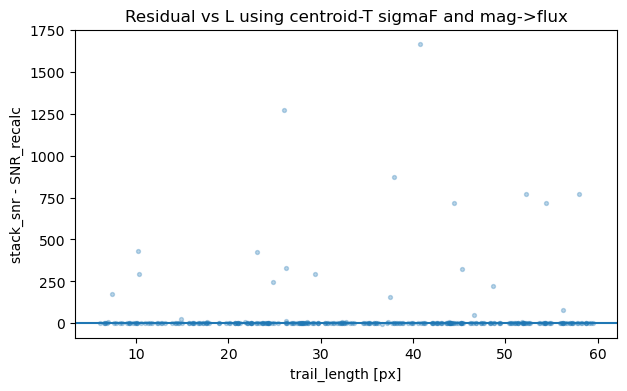

mean resid: 34.28729199455436 std: 163.3604719536537


In [12]:
# Cell 11 — interpret what you should do next (numeric summary you can compare after each tweak)
# This focuses on the SNR mismatch: if sigmaF changes little between old and centroid methods,
# then centering is *not* the main culprit.

# 1) How much does sigmaF change?  (already plotted)
# 2) Does residual-vs-L change if you recompute sigmaF with centroid method and re-derive "SNR"?
#    If your injection "SNR" was computed from sigmaF, recompute a "SNR_recalc" from flux and sigmaF_cen.

# For this, we need the instrumental flux used in injection.
# If you have "integrated_mag" or "PSF_mag" in CSV, use PhotoCalib to get instFlux at that position.
# Here is a minimal version using integrated_mag -> instFlux, and then SNR = F/sigmaF.

def recompute_snr_from_mag(row, mag_col="integrated_mag", use_kernel=True, step=0.15):
    calexp, _ = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])
    mag = float(row[mag_col])

    # compute sigmaF with centroid T
    so, sc, _ = compare_sigmaF(row, use_kernel=use_kernel, step=step)
    if not np.isfinite(sc) or sc<=0:
        return np.nan

    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
    return F/sc

# only run if mag column exists
mag_col = "integrated_mag" if "integrated_mag" in d.columns else None
print("mag_col:", mag_col)

if mag_col is not None:
    ss = d.sample(n=min(300, len(d)), random_state=2).copy()
    snr_re = []
    for _, row in ss.iterrows():
        snr_re.append(recompute_snr_from_mag(row, mag_col=mag_col, use_kernel=True, step=0.15))
    ss["SNR_recalc"] = snr_re
    ss = ss.dropna(subset=["SNR_recalc"])
    ss["resid_recalc"] = ss["stack_snr"] - ss["SNR_recalc"]

    plt.figure(figsize=(7,4))
    plt.scatter(ss["trail_length"], ss["resid_recalc"], s=8, alpha=0.3)
    plt.axhline(0)
    plt.xlabel("trail_length [px]")
    plt.ylabel("stack_snr - SNR_recalc")
    plt.title("Residual vs L using centroid-T sigmaF and mag->flux")
    plt.show()

    print("mean resid:", ss["resid_recalc"].mean(), "std:", ss["resid_recalc"].std())
else:
    print("No integrated_mag column found; skip this cell or adapt to your mag convention.")


# Test 2

N raw: 11843 N clipped: 10329
raw resid mean/std: 25.22421947817636 148.8550542646831
clipped resid mean/std: 0.9715266873455791 1.2327402347001315
clipped resid median: 0.9684679832167618 MAD: 0.7290685016593068


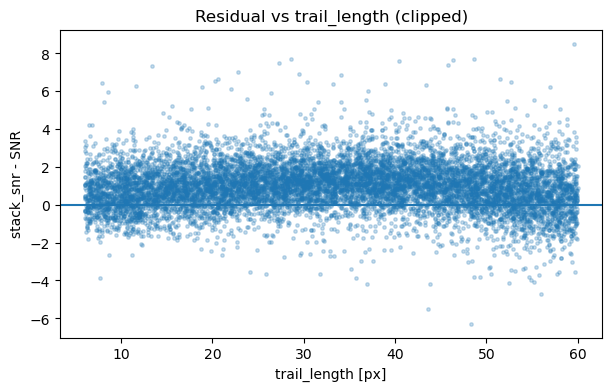

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dd = d.copy()
dd["resid"] = dd["stack_snr"] - dd["SNR"]

# Hard sanity cuts on stack_snr; tune if needed.
dd1 = dd[(dd["stack_snr"] > 0) & (dd["stack_snr"] < 11) & (dd["SNR"] > 0) & (dd["SNR"] < 50)].copy()

print("N raw:", len(dd), "N clipped:", len(dd1))
print("raw resid mean/std:", dd["resid"].mean(), dd["resid"].std())
print("clipped resid mean/std:", dd1["resid"].mean(), dd1["resid"].std())

# robust summary
med = np.median(dd1["resid"])
mad = np.median(np.abs(dd1["resid"] - med))
print("clipped resid median:", med, "MAD:", mad)

plt.figure(figsize=(7,4))
plt.scatter(dd1["trail_length"], dd1["resid"], s=6, alpha=0.25)
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - SNR")
plt.title("Residual vs trail_length (clipped)")
plt.show()


CSV point offset to mask-centroid:  median dx,dy: 0.0 0.0
Midpoint(start->mid) offset to mask-centroid: median dx,dy: -0.7850347558115658 -10.263065752138345


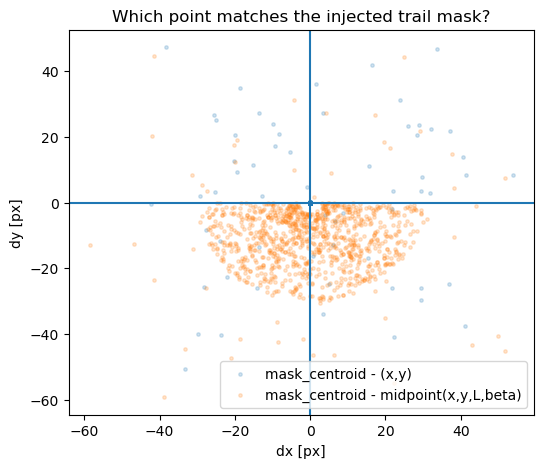

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def mask_centroid(mask_stamp):
    yy, xx = np.mgrid[0:mask_stamp.shape[0], 0:mask_stamp.shape[1]]
    m = mask_stamp.astype(np.float64)
    tot = m.sum()
    if tot <= 0:
        return np.nan, np.nan
    cx = (xx*m).sum()/tot
    cy = (yy*m).sum()/tot
    return float(cx), float(cy)

def start_to_midpoint_xy(x0, y0, L_pix, beta_deg):
    th = np.deg2rad(beta_deg)
    return x0 + 0.5*L_pix*np.cos(th), y0 + 0.5*L_pix*np.sin(th)

# sample a bunch
ss = d.sample(n=min(1000, len(d)), random_state=0).copy()

dxs, dys, dxm, dym = [], [], [], []

for _, row in ss.iterrows():
    img_id = int(row["image_id"])
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])

    m = masks[img_id].astype(bool)
    m_s, x0, y0 = cutout(m, x, y, half=96)     # same cutout you already use

    mcx, mcy = mask_centroid(m_s)
    if not np.isfinite(mcx):
        continue

    # CSV (x,y) position inside stamp
    xs = x - x0
    ys = y - y0

    # midpoint from CSV start assumption
    xm, ym = start_to_midpoint_xy(x, y, L, th)
    xms = xm - x0
    yms = ym - y0

    dxs.append(mcx - xs);  dys.append(mcy - ys)    # mask centroid - CSV point
    dxm.append(mcx - xms); dym.append(mcy - yms)   # mask centroid - midpoint(start->mid)

dxs = np.array(dxs); dys = np.array(dys)
dxm = np.array(dxm); dym = np.array(dym)

print("CSV point offset to mask-centroid:  median dx,dy:", np.median(dxs), np.median(dys))
print("Midpoint(start->mid) offset to mask-centroid: median dx,dy:", np.median(dxm), np.median(dym))

plt.figure(figsize=(6,5))
plt.scatter(dxs, dys, s=6, alpha=0.2, label="mask_centroid - (x,y)")
plt.scatter(dxm, dym, s=6, alpha=0.2, label="mask_centroid - midpoint(x,y,L,beta)")
plt.axvline(0); plt.axhline(0)
plt.xlabel("dx [px]"); plt.ylabel("dy [px]")
plt.legend()
plt.title("Which point matches the injected trail mask?")
plt.show()


In [15]:
import numpy as np
import traceback
from collections import Counter

# Make sure these exist from your notebook context:
# ss (sample dataframe), masks (H5 masks array), get_calexp_for_row, cutout, mask_centroid,
# psf_fit_flux_sigma, start_to_midpoint_xy (or whatever you actually have)

why = Counter()
fail_examples = []  # store a few detailed failures
out = []

MAX_FAIL_PRINT = 5

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
    except Exception as e:
        why["calexp_fail"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("calexp_fail", repr(e), dict(row), traceback.format_exc()))
        continue

    try:
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])
        img_id = int(row["image_id"])
    except Exception as e:
        why["row_parse_fail"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("row_parse_fail", repr(e), dict(row), traceback.format_exc()))
        continue

    # midpoint: THIS IS A COMMON HIDDEN FAILURE (wrong function name / NaNs / wrong units)
    try:
        # use the function you truly have:
        # x_mid, y_mid = start_to_midpoint_xy(x0, y0, L, th)
        x_mid, y_mid = start_to_midpoint(x0, y0, L, th)  # change if needed
    except Exception as e:
        why["midpoint_fail"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("midpoint_fail", repr(e),
                                 {"x0":x0,"y0":y0,"L":L,"th":th,"visit":row.get("visit"),"det":row.get("detector")},
                                 traceback.format_exc()))
        continue

    # mask centroid position
    try:
        m = masks[img_id].astype(bool)
        m_s, xcut0, ycut0 = cutout(m, x0, y0, half=96)
        mcx, mcy = mask_centroid(m_s)
        if not np.isfinite(mcx):
            why["mask_centroid_nan"] += 1
            continue
        x_mask = xcut0 + mcx
        y_mask = ycut0 + mcy
    except Exception as e:
        why["mask_center_fail"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("mask_center_fail", repr(e),
                                 {"img_id":img_id,"x0":x0,"y0":y0,"visit":row.get("visit"),"det":row.get("detector")},
                                 traceback.format_exc()))
        continue

    # sigmaF block: capture the *real* exception + which call triggered it
    try:
        s0   = psf_fit_flux_sigma(calexp, x0,    y0,    L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0)
        smid = psf_fit_flux_sigma(calexp, x_mid, y_mid, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0)
        smsk = psf_fit_flux_sigma(calexp, x_mask,y_mask,L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0)
    except Exception as e:
        why["sigmaF_exception"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("sigmaF_exception", repr(e),
                                 {"x0":x0,"y0":y0,"x_mid":x_mid,"y_mid":y_mid,"x_mask":x_mask,"y_mask":y_mask,
                                  "L":L,"th":th,"visit":row.get("visit"),"det":row.get("detector")},
                                 traceback.format_exc()))
        continue

    # non-finite sigmaFs (this is separate from exceptions)
    if not (np.isfinite(s0) and np.isfinite(smid) and np.isfinite(smsk)):
        why["sigmaF_nonfinite"] += 1
        continue

    # compute model snrs
    try:
        F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
        snr0   = F / s0
        snrmid = F / smid
        snrmsk = F / smsk
    except Exception as e:
        why["snr_compute_fail"] += 1
        if len(fail_examples) < MAX_FAIL_PRINT:
            fail_examples.append(("snr_compute_fail", repr(e),
                                 {"mag":mag,"visit":row.get("visit"),"det":row.get("detector")},
                                 traceback.format_exc()))
        continue

    out.append((L, stack_snr, snr0, snrmid, snrmsk))

print("Counts:", dict(why))

print("\nFirst failing examples (up to 5):")
for k, e, info, tb in fail_examples:
    print("\n---", k, "---")
    print("Exception:", e)
    print("Info:", info)
    print(tb)



KeyboardInterrupt



In [ ]:
print("type(ss):", type(ss))
try:
    print("len(ss):", len(ss))
    print("ss columns:", list(ss.columns)[:20], "...")
except Exception as e:
    print("Could not inspect ss:", repr(e))

print("type(out):", type(out))
print("len(out):", len(out))

# show first 3 out rows if any
if len(out) > 0:
    print("First 3 out rows:")
    for r in out[:3]:
        print(r)
else:
    print("out is empty -> either ss empty OR all rows skipped by NaN/nonfinite checks.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

out_arr = np.asarray(out, dtype=float)
L     = out_arr[:,0]
stack = out_arr[:,1]
snr0  = out_arr[:,2]
snrm  = out_arr[:,3]
snrk  = out_arr[:,4]

# Basic sanity filters
good = np.isfinite(L) & np.isfinite(stack) & np.isfinite(snr0) & np.isfinite(snrm) & np.isfinite(snrk)

# remove insane stack SNR (your example 437)
# tune these cutoffs as needed; start conservative
good &= (stack > 0) & (stack < 50)
good &= (snr0 > 0) & (snr0 < 50)

Lg = L[good]
rg0   = stack[good] - snr0[good]
rgm   = stack[good] - snrm[good]
rgk   = stack[good] - snrk[good]

print("N total:", len(out_arr), "N good:", good.sum())
for name, rr in [("(x,y)", rg0), ("midpoint", rgm), ("mask-centroid", rgk)]:
    med = np.median(rr)
    mad = np.median(np.abs(rr - med))
    print(f"{name:13s} median={med: .3f}  MAD={mad: .3f}")

plt.figure(figsize=(7,4))
plt.scatter(Lg, rg0, s=10, alpha=0.3, label="stack - model @ (x,y)")
plt.scatter(Lg, rgm, s=10, alpha=0.3, label="stack - model @ midpoint")
plt.scatter(Lg, rgk, s=10, alpha=0.3, label="stack - model @ mask-centroid")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - model_snr")
plt.legend()
plt.title("Residual vs trail length (filtered)")
plt.show()

# Binned trend
bins = np.linspace(Lg.min(), Lg.max(), 10)
cent = 0.5*(bins[:-1]+bins[1:])
def binned_median(x, y, bins):
    outm = []
    for a,b in zip(bins[:-1], bins[1:]):
        m = (x>=a) & (x<b)
        outm.append(np.median(y[m]) if np.any(m) else np.nan)
    return np.asarray(outm)

bm0 = binned_median(Lg, rg0, bins)
plt.figure(figsize=(7,4))
plt.plot(cent, bm0, marker="o")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("median(stack-model) in bin")
plt.title("Binned median residual (using (x,y))")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ss = d.sample(n=min(200, len(d)), random_state=2).copy()
rows = []
for _, row in ss.iterrows():
    calexp, _ = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"])
    mag = float(row["integrated_mag"])
    stack = float(row["stack_snr"])
    th0 = float(row["beta"])

    res = []
    for dth in [0.0, 90.0, 180.0, 270.0]:
        th = th0 + dth
        s = psf_fit_flux_sigma(calexp, x, y, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0)
        if not (np.isfinite(s) and s > 0):
            res.append(np.nan)
            continue
        snr = model_snr_from_mag(calexp, mag, s)
        res.append(stack - snr)
    rows.append((L, *res))

rows = np.array(rows, dtype=float)
L = rows[:,0]
labels = ["beta", "beta+90", "beta+180", "beta+270"]

plt.figure(figsize=(7,4))
for j in range(4):
    rr = rows[:,1+j]
    ok = np.isfinite(rr)
    plt.scatter(L[ok], rr[ok], s=8, alpha=0.25, label=labels[j])
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - model_snr")
plt.ylim((0,5))
plt.legend()
plt.title("Angle convention test")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

steps = [0.30, 0.20, 0.15, 0.10, 0.07]
ss = d.sample(n=min(120, len(d)), random_state=3).copy()

by_step = {st: [] for st in steps}

for _, row in ss.iterrows():
    calexp, _ = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])
    mag = float(row["integrated_mag"])
    stack = float(row["stack_snr"])

    for st in steps:
        try:
            s = psf_fit_flux_sigma(calexp, x, y, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0)
            # NOTE: psf_fit_flux_sigma uses your internal step; to truly test,
            # expose 'step' as an argument and pass it down to _trail_template_for_stamp.
        except Exception:
            continue
        if not (np.isfinite(s) and s > 0):
            continue
        snr = model_snr_from_mag(calexp, mag, s)
        by_step[st].append((L, stack - snr))

plt.figure(figsize=(7,4))
for st in steps:
    arr = np.array(by_step[st])
    if len(arr) == 0:
        continue
    plt.scatter(arr[:,0], arr[:,1], s=8, alpha=0.25, label=f"step={st}")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - model_snr")
plt.ylim((0,5))
plt.legend()
plt.title("Residual vs L for different step (requires exposing step in code)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ss = d.sample(n=min(200, len(d)), random_state=4).copy()

L_list, r_img, r_ker = [], [], []
for _, row in ss.iterrows():
    calexp, _ = get_calexp_for_row(row)
    x = float(row["x"]); y = float(row["y"])
    L = float(row["trail_length"]); th = float(row["beta"])
    mag = float(row["integrated_mag"])
    stack = float(row["stack_snr"])

    s_img = psf_fit_flux_sigma(calexp, x, y, L_pix=L, theta_deg=th, use_kernel_image=False, pad_sigma=5.0)
    s_ker = psf_fit_flux_sigma(calexp, x, y, L_pix=L, theta_deg=th, use_kernel_image=True,  pad_sigma=5.0)

    if not (np.isfinite(s_img) and np.isfinite(s_ker) and s_img>0 and s_ker>0):
        continue

    snr_img = model_snr_from_mag(calexp, mag, s_img)
    snr_ker = model_snr_from_mag(calexp, mag, s_ker)

    L_list.append(L)
    r_img.append(stack - snr_img)
    r_ker.append(stack - snr_ker)

plt.figure(figsize=(7,4))
plt.scatter(L_list, r_img, s=8, alpha=0.25, label="PSF computeImage")
plt.scatter(L_list, r_ker, s=8, alpha=0.25, label="PSF computeKernelImage")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - model_snr")
plt.ylim((0,5))
plt.legend()
plt.title("PSF choice test")
plt.show()

print("median resid computeImage:", np.median(r_img))
print("median resid computeKernelImage:", np.median(r_ker))


# Test 3

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def model_snr_from_mag(calexp, mag, sigmaF):
    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))
    return F / float(sigmaF)

def binned_median(x, y, bins):
    idx = np.digitize(x, bins) - 1
    out = []
    for k in range(len(bins)-1):
        m = idx == k
        if np.any(m):
            out.append((0.5*(bins[k]+bins[k+1]), np.median(y[m]), np.sum(m)))
    return np.array(out, dtype=float)


In [17]:
from collections import Counter
why = Counter()

# pick a small sample first (butler IO is expensive)
ss = d.sample(n=min(150, len(d)), random_state=1).copy()

rows = []
for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        stack_snr = float(row["stack_snr"])

        # sigmaF at (x,y) midpoint (your catalog point)
        sigmaF = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if not np.isfinite(sigmaF):
            why["sigmaF_nonfinite"] += 1
            continue

        snr_int = model_snr_from_mag(calexp, row["integrated_mag"], sigmaF)
        snr_psf = model_snr_from_mag(calexp, row["PSF_mag"],       sigmaF)

        rows.append((L, stack_snr, snr_int, snr_psf))
    except Exception:
        why["exception"] += 1
        continue

Counts: {}
Median residual (integrated_mag): 1.524476881399555
Median residual (PSF_mag):       4.1195321398428


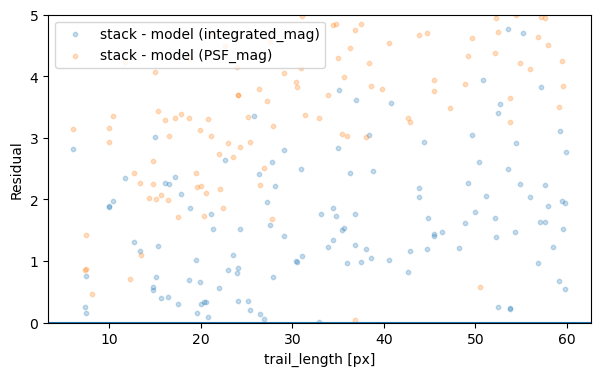

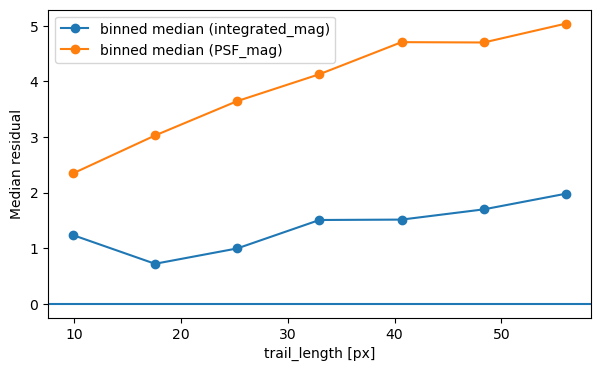

In [18]:
print("Counts:", dict(why))
rows = np.asarray(rows, float)

L = rows[:,0]
res_int = rows[:,1] - rows[:,2]
res_psf = rows[:,1] - rows[:,3]

print("Median residual (integrated_mag):", np.median(res_int))
print("Median residual (PSF_mag):      ", np.median(res_psf))

plt.figure(figsize=(7,4))
plt.scatter(L, res_int, s=10, alpha=0.25, label="stack - model (integrated_mag)")
plt.scatter(L, res_psf, s=10, alpha=0.25, label="stack - model (PSF_mag)")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual")
plt.ylim((0,5))
plt.legend()
plt.show()

bins = np.linspace(L.min(), L.max(), 8)
bm_int = binned_median(L, res_int, bins)
bm_psf = binned_median(L, res_psf, bins)

plt.figure(figsize=(7,4))
plt.plot(bm_int[:,0], bm_int[:,1], marker="o", label="binned median (integrated_mag)")
plt.plot(bm_psf[:,0], bm_psf[:,1], marker="o", label="binned median (PSF_mag)")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Median residual")
plt.legend()
plt.show()

In [19]:
steps = [0.40, 0.25, 0.15, 0.10, 0.07]

ss2 = d.sample(n=min(80, len(d)), random_state=2).copy()

out = []
for st in steps:
    rr = []
    LL = []
    for _, row in ss2.iterrows():
        try:
            calexp, _ = get_calexp_for_row(row)
            x0 = float(row["x"]); y0 = float(row["y"])
            L  = float(row["trail_length"]); th = float(row["beta"])
            stack_snr = float(row["stack_snr"])

            sigmaF = psf_fit_flux_sigma(
                calexp, x0, y0,
                L_pix=L, theta_deg=th,
                use_kernel_image=True,
                pad_sigma=5.0,
                step=st,
            )
            if not np.isfinite(sigmaF):
                continue
            snr_model = model_snr_from_mag(calexp, row["integrated_mag"], sigmaF)
            rr.append(stack_snr - snr_model)
            LL.append(L)
        except Exception:
            continue

    rr = np.asarray(rr, float)
    LL = np.asarray(LL, float)
    out.append((st, np.median(rr), np.median(np.abs(rr - np.median(rr))), len(rr)))
    print("step=", st, "N=", len(rr), "median=", np.median(rr))

print("\nSummary (step, median, MAD, N):")
print(np.array(out))


step= 0.4 N= 80 median= 1.7460374051426306
step= 0.25 N= 80 median= 1.714802417577375
step= 0.15 N= 80 median= 1.6982879294069437
step= 0.1 N= 80 median= 1.692815232975566
step= 0.07 N= 80 median= 1.6884656028500464

Summary (step, median, MAD, N):
[[4.00000000e-01 1.74603741e+00 8.37114722e-01 8.00000000e+01]
 [2.50000000e-01 1.71480242e+00 8.52480576e-01 8.00000000e+01]
 [1.50000000e-01 1.69828793e+00 8.53881086e-01 8.00000000e+01]
 [1.00000000e-01 1.69281523e+00 8.52663685e-01 8.00000000e+01]
 [7.00000000e-02 1.68846560e+00 8.51188371e-01 8.00000000e+01]]


Median residual (with variance): 1.5992111046011006
Median residual (const var=1):  -302.8436229276415


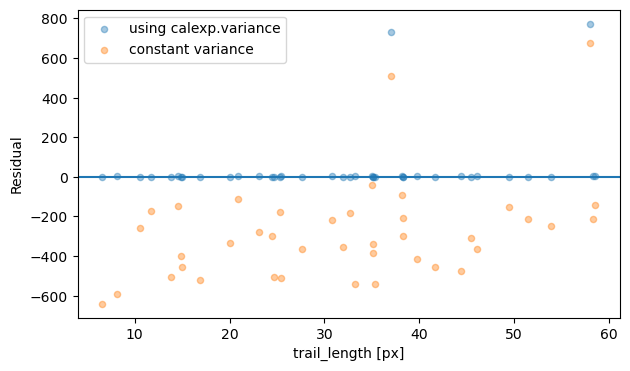

In [20]:
ss3 = d.sample(n=min(40, len(d)), random_state=3).copy()

res_v = []
res_const = []
Ls = []

for _, row in ss3.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        stack_snr = float(row["stack_snr"])
        mag = float(row["integrated_mag"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0, L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
        if phi is None or T is None or v_cut is None:
            continue
        if not np.isfinite(sigmaF):
            continue

        F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
        snr_model_v = F / sigmaF

        # recompute sigmaF with constant variance (=1) on same stamps
        good = np.isfinite(phi) & np.isfinite(T)
        denom_c = np.sum(phi[good]**2)
        over_c  = np.sum(phi[good]*T[good])
        if denom_c <= 0 or over_c <= 0:
            continue
        sigmaF_const = np.sqrt(denom_c) / over_c
        snr_model_const = F / sigmaF_const

        res_v.append(stack_snr - snr_model_v)
        res_const.append(stack_snr - snr_model_const)
        Ls.append(L)
    except Exception:
        continue

res_v = np.asarray(res_v)
res_const = np.asarray(res_const)
Ls = np.asarray(Ls)

print("Median residual (with variance):", np.median(res_v))
print("Median residual (const var=1): ", np.median(res_const))

plt.figure(figsize=(7,4))
plt.scatter(Ls, res_v, s=20, alpha=0.4, label="using calexp.variance")
plt.scatter(Ls, res_const, s=20, alpha=0.4, label="constant variance")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual")
plt.legend()
plt.show()


Kept: 40 of 40
Drop reasons: {}
Median residual (with variance): 1.5992111046011006
Median residual (const var=1):  -302.8436229276415


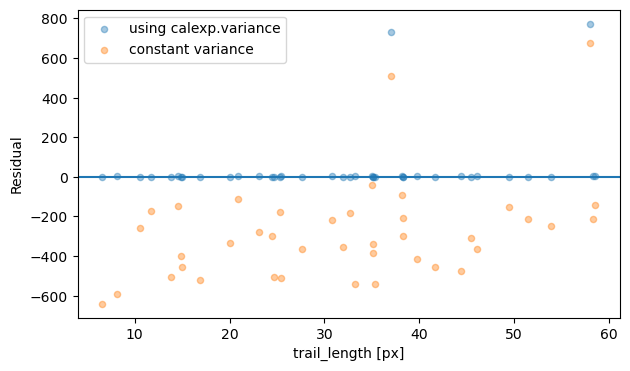

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

ss3 = d.sample(n=min(40, len(d)), random_state=3).copy()

why = Counter()
res_v = []
res_const = []
Ls = []

for _, row in ss3.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        stack_snr = float(row["stack_snr"])
        mag = float(row["integrated_mag"])

        if not np.isfinite(stack_snr):
            why["stack_snr_nonfinite"] += 1
            continue
        if not np.isfinite(mag):
            why["mag_nonfinite"] += 1
            continue

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0, L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )

        if phi is None or T is None:
            why["phi_or_T_none"] += 1
            continue
        if not (np.isfinite(sigmaF) and sigmaF > 0):
            why["sigmaF_bad"] += 1
            continue

        F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
        if not (np.isfinite(F) and F > 0):
            why["F_bad"] += 1
            continue

        snr_model_v = F / sigmaF
        if not np.isfinite(snr_model_v):
            why["snr_model_v_bad"] += 1
            continue

        # const-var sigmaF on same stamps
        good = np.isfinite(phi) & np.isfinite(T)
        if good.sum() == 0:
            why["no_good_pixels"] += 1
            continue

        denom_c = float(np.sum(phi[good] ** 2))
        over_c  = float(np.sum(phi[good] * T[good]))
        if not (np.isfinite(denom_c) and np.isfinite(over_c) and denom_c > 0 and over_c > 0):
            why["const_terms_bad"] += 1
            continue

        sigmaF_const = np.sqrt(denom_c) / over_c
        if not (np.isfinite(sigmaF_const) and sigmaF_const > 0):
            why["sigmaF_const_bad"] += 1
            continue

        snr_model_const = F / sigmaF_const
        if not np.isfinite(snr_model_const):
            why["snr_model_const_bad"] += 1
            continue

        rv = stack_snr - snr_model_v
        rc = stack_snr - snr_model_const
        if not (np.isfinite(rv) and np.isfinite(rc)):
            why["residual_nonfinite"] += 1
            continue

        res_v.append(rv)
        res_const.append(rc)
        Ls.append(L)

    except Exception as e:
        print (e)
        why["exception"] += 1
        continue

res_v = np.asarray(res_v, float)
res_const = np.asarray(res_const, float)
Ls = np.asarray(Ls, float)

print("Kept:", len(res_v), "of", len(ss3))
print("Drop reasons:", dict(why))

if len(res_v) == 0:
    raise RuntimeError("No rows survived; see Drop reasons above.")

print("Median residual (with variance):", np.nanmedian(res_v))
print("Median residual (const var=1): ", np.nanmedian(res_const))

plt.figure(figsize=(7,4))
plt.scatter(Ls, res_v, s=20, alpha=0.4, label="using calexp.variance")
plt.scatter(Ls, res_const, s=20, alpha=0.4, label="constant variance")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual")
plt.legend()
plt.show()


In [22]:
# pick one row to test
row = d.sample(1, random_state=0).iloc[0]

visit = int(row["visit"]); det = int(row["detector"])
dataId = {"visit": visit, "detector": det}

# load both products (adjust dataset type names if needed in your repo/collection)
calexp_pre = butler.get("preliminary_visit_image", dataId=dataId)
# calexp_full = butler.get("calexp", dataId=dataId)  # only if available in your collection

x0 = float(row["x"]); y0 = float(row["y"])
L  = float(row["trail_length"]); th = float(row["beta"])

s_pre = psf_fit_flux_sigma(calexp_pre, x0, y0, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15)
print("sigmaF preliminary:", s_pre)

# if you can load calexp:
# s_full = psf_fit_flux_sigma(calexp_full, x0, y0, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15)
# print("sigmaF calexp:", s_full)


sigmaF preliminary: 3026.077568917542


N: 11843
median(stack_snr / (1.0857/merr)): 0.9999999999999997


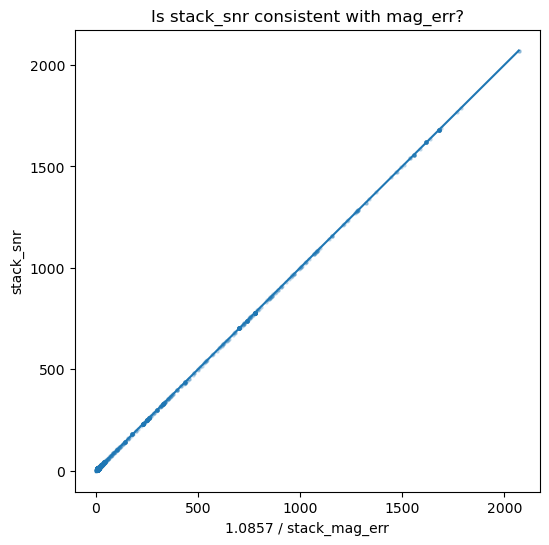

In [23]:
import numpy as np
import matplotlib.pyplot as plt

dd = d.copy()
dd = dd.replace([np.inf, -np.inf], np.nan)

merr = dd["stack_mag_err"].to_numpy(dtype=float)
snr_from_merr = 1.0857362047581294 / merr  # 2.5/ln(10)

stack_snr = dd["stack_snr"].to_numpy(dtype=float)

m = np.isfinite(snr_from_merr) & np.isfinite(stack_snr) & (merr > 0) & (stack_snr > 0)
print("N:", m.sum())
print("median(stack_snr / (1.0857/merr)):", np.median(stack_snr[m] / snr_from_merr[m]))

plt.figure(figsize=(6,6))
plt.scatter(snr_from_merr[m], stack_snr[m], s=5, alpha=0.2)
plt.plot([0, np.nanmax(snr_from_merr[m])],[0, np.nanmax(snr_from_merr[m])])
plt.xlabel("1.0857 / stack_mag_err")
plt.ylabel("stack_snr")
plt.title("Is stack_snr consistent with mag_err?")
plt.show()


stack_snr percentiles: [1.48778486e-01 5.10621467e+00 5.39935970e+00 8.00402483e+00
 2.44631447e+01 7.78485625e+02 1.67732810e+03]


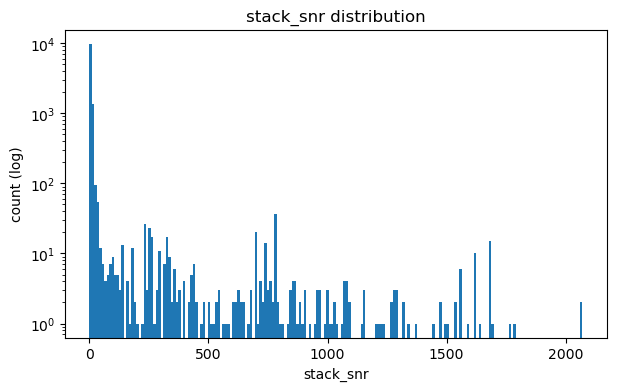

In [24]:
s = d["stack_snr"].to_numpy(float)
print("stack_snr percentiles:", np.nanpercentile(s[np.isfinite(s)], [0,1,5,50,95,99,99.9]))

plt.figure(figsize=(7,4))
plt.hist(s[np.isfinite(s)], bins=200)
plt.yscale("log")
plt.xlabel("stack_snr")
plt.ylabel("count (log)")
plt.title("stack_snr distribution")
plt.show()


stack_mag - integrated_mag: median 1.189338382499745
stack_mag - PSF_mag:       median 0.5780330984961086


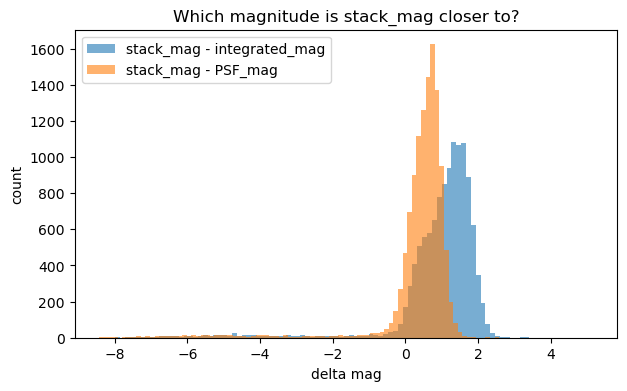

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def dm(a,b):
    m = np.isfinite(a) & np.isfinite(b)
    return (a[m]-b[m])

dm_int = dm(d["stack_mag"].to_numpy(float), d["integrated_mag"].to_numpy(float))
dm_psf = dm(d["stack_mag"].to_numpy(float), d["PSF_mag"].to_numpy(float))

print("stack_mag - integrated_mag: median", np.median(dm_int))
print("stack_mag - PSF_mag:       median", np.median(dm_psf))

plt.figure(figsize=(7,4))
plt.hist(dm_int, bins=100, alpha=0.6, label="stack_mag - integrated_mag")
plt.hist(dm_psf, bins=100, alpha=0.6, label="stack_mag - PSF_mag")
plt.xlabel("delta mag")
plt.ylabel("count")
plt.legend()
plt.title("Which magnitude is stack_mag closer to?")
plt.show()


N kept: 60 bad exceptions: 0
median overlap_emp/overlap_model: 0.9308433905444241


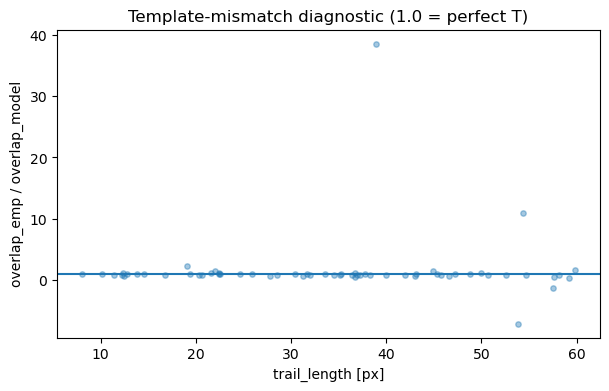

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# You need:
# - imgs: H5 image cutouts aligned with masks, same indexing by image_id
# - function get_calexp_for_row(row)
# - function cutout(img, x, y, half=...) returning stamp + x0,y0 in full coords
# - psf_fit_flux_sigma_debug returning phi, T, v_cut on the same out_shape

def robust_bg_subtract(stamp):
    # very simple robust background estimate (median)
    return stamp - np.nanmedian(stamp)

ssC = d.sample(n=min(60, len(d)), random_state=123).copy()

Ls, ratio = [], []
bad = 0

for _, row in ssC.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        img_id = int(row["image_id"])

        # Build model phi, T, V on large stamp (same as sigmaF)
        sigmaF, denom_phi, overlap_model, phi, Tm, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0, L_pix=L, theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
        if phi is None or Tm is None or v_cut is None:
            continue

        # Get the actual injected image stamp from H5, cut around (x0,y0)
        im = imgs[img_id].astype(np.float64)  # adjust name to yours
        im_s, _, _ = cutout(im, x0, y0, half=(phi.shape[0]//2))  # match size
        if im_s.shape != phi.shape:
            continue

        I = robust_bg_subtract(im_s)

        # total flux from integrated_mag using same photoCalib
        F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
        if not (np.isfinite(F) and F > 0):
            continue

        good = np.isfinite(phi) & np.isfinite(v_cut) & (v_cut > 0) & np.isfinite(I)
        if good.sum() < 100:
            continue

        overlap_emp = np.sum(phi[good] * I[good] / v_cut[good]) / F

        if overlap_model <= 0 or not np.isfinite(overlap_emp):
            continue

        Ls.append(L)
        ratio.append(overlap_emp / overlap_model)

    except Exception:
        bad += 1
        continue

N kept: 60 bad exceptions: 0
median overlap_emp/overlap_model: 0.9308433905444241


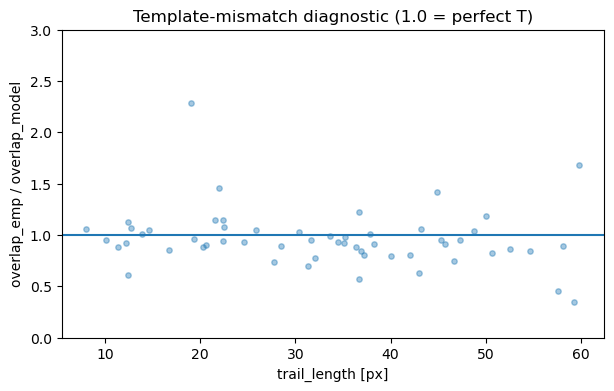

In [28]:
Ls = np.asarray(Ls, float)
ratio = np.asarray(ratio, float)

print("N kept:", len(Ls), "bad exceptions:", bad)
print("median overlap_emp/overlap_model:", np.median(ratio))

plt.figure(figsize=(7,4))
plt.scatter(Ls, ratio, s=15, alpha=0.4)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("overlap_emp / overlap_model")
plt.ylim(0,3)
plt.title("Template-mismatch diagnostic (1.0 = perfect T)")
plt.show()

Counts: {'bad_denom_or_overlap': 1}
Survived: 199
SNR residual: median = 1.4035553216217451  MAD = 0.8354419688814447
Mag residual: median = -0.19085465841892812  MAD = 0.12193365482781005


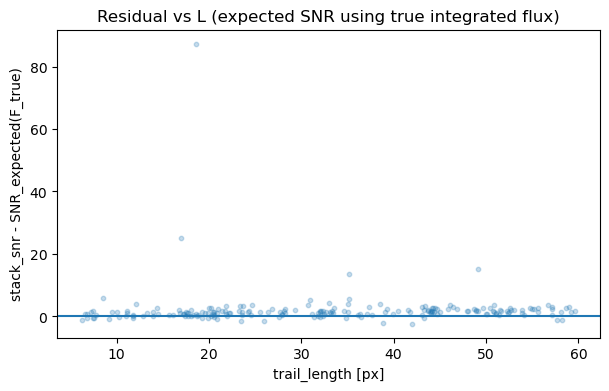

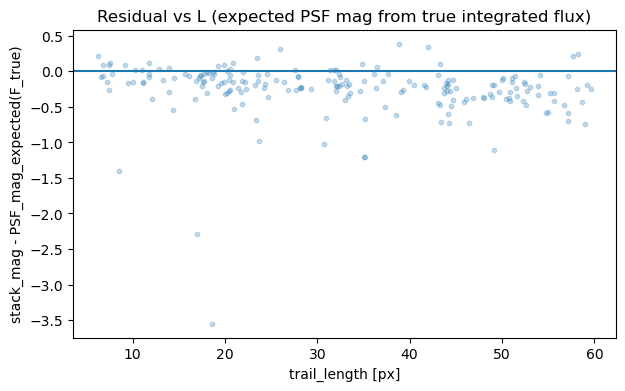

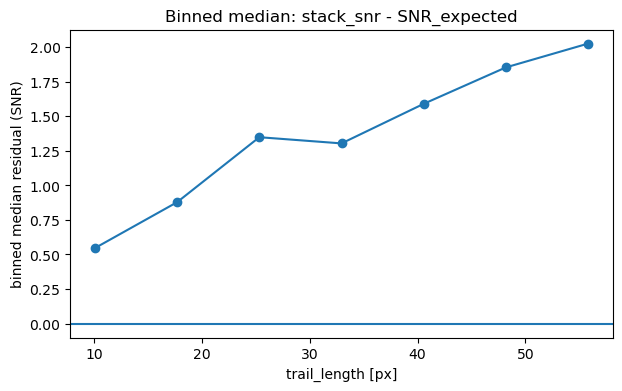

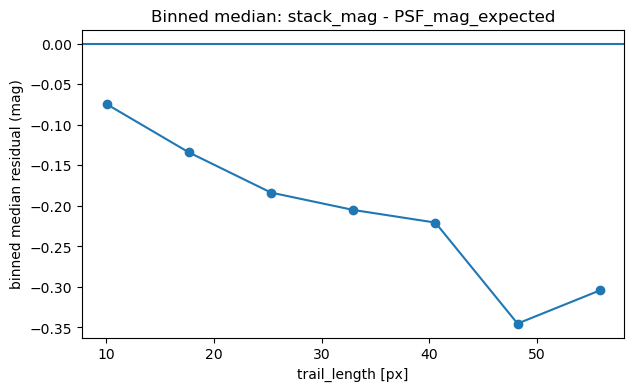

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def binned_median(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        m = (x >= lo) & (x < hi) & np.isfinite(y)
        if np.any(m):
            out.append(((lo + hi) / 2.0, np.median(y[m]), np.sum(m)))
    return np.asarray(out, float)

why = Counter()

ssA = d.sample(n=min(200, len(d)), random_state=11).copy()

rowsA = []
for _, row in ssA.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        mag_true = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])
        stack_mag = float(row["stack_mag"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15
        )

        if not (np.isfinite(denom_phi) and np.isfinite(overlap) and denom_phi > 0 and overlap > 0):
            why["bad_denom_or_overlap"] += 1
            continue

        # true injected flux (from integrated_mag)
        F_true = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag_true))

        # Expected SNR of PSF-flux estimator when the true image is F_true*T
        # SNR_exp = F_true * overlap / sqrt(denom_phi)
        snr_exp = F_true * (overlap / np.sqrt(denom_phi))

        # Expected *PSF-flux amplitude* returned by the estimator:
        # F_psf_exp = F_true * overlap / denom_phi
        F_psf_exp = F_true * (overlap / denom_phi)
        if not (np.isfinite(F_psf_exp) and F_psf_exp > 0):
            why["bad_Fpsf_exp"] += 1
            continue

        psf_mag_exp = float(calexp.getPhotoCalib().instFluxToMagnitude(F_psf_exp))

        rowsA.append((
            L,
            stack_snr,
            snr_exp,
            stack_mag,
            psf_mag_exp,
            denom_phi,
            overlap
        ))

    except Exception:
        why["exception"] += 1
        continue

print("Counts:", dict(why))
rowsA = np.asarray(rowsA, float)
print("Survived:", len(rowsA))

if len(rowsA) == 0:
    raise RuntimeError("No rows survived Cell A; check Counts above.")

L = rowsA[:,0]
stack_snr = rowsA[:,1]
snr_exp   = rowsA[:,2]
stack_mag = rowsA[:,3]
psf_mag_exp = rowsA[:,4]

res_snr = stack_snr - snr_exp
res_mag = stack_mag - psf_mag_exp

print("SNR residual: median =", np.median(res_snr), " MAD =", np.median(np.abs(res_snr - np.median(res_snr))))
print("Mag residual: median =", np.median(res_mag), " MAD =", np.median(np.abs(res_mag - np.median(res_mag))))

plt.figure(figsize=(7,4))
plt.scatter(L, res_snr, s=10, alpha=0.25)
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - SNR_expected(F_true)")
plt.title("Residual vs L (expected SNR using true integrated flux)")
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(L, res_mag, s=10, alpha=0.25)
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_mag - PSF_mag_expected(F_true)")
plt.title("Residual vs L (expected PSF mag from true integrated flux)")
plt.show()

bins = np.linspace(np.nanmin(L), np.nanmax(L), 8)
bm_snr = binned_median(L, res_snr, bins)
bm_mag = binned_median(L, res_mag, bins)

plt.figure(figsize=(7,4))
plt.plot(bm_snr[:,0], bm_snr[:,1], marker="o")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("binned median residual (SNR)")
plt.title("Binned median: stack_snr - SNR_expected")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(bm_mag[:,0], bm_mag[:,1], marker="o")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("binned median residual (mag)")
plt.title("Binned median: stack_mag - PSF_mag_expected")
plt.show()


Counts: {}
Survived: 200
Median residual (integrated_mag): 1.5016834696921006  MAD: 1.0260399755915077
Median residual (PSF_mag):       4.14183943744538  MAD: 1.2253141417632287


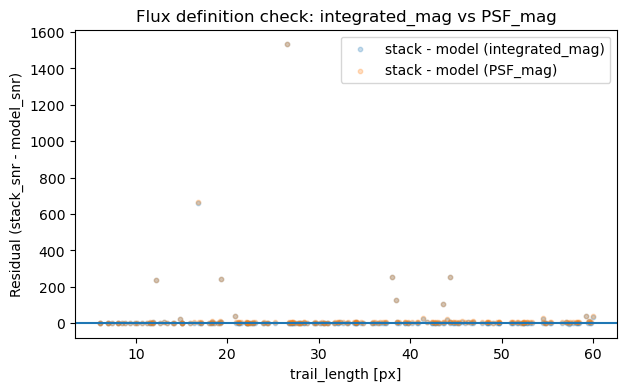

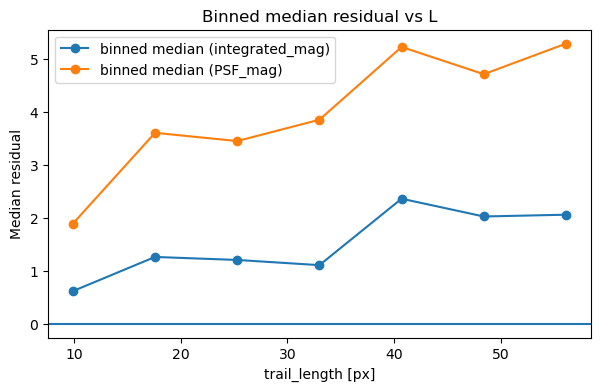

In [30]:
# Cell B: Directly compare "model SNR" using integrated_mag vs PSF_mag (same sigmaF),
# to see which flux definition aligns with stack_snr.
#
# Requires:
# - d, get_calexp_for_row
# - psf_fit_flux_sigma(calexp, x, y, L_pix, theta_deg, use_kernel_image, pad_sigma, step)

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

why = Counter()

ssB = d.sample(n=min(200, len(d)), random_state=22).copy()

rowsB = []
for _, row in ssB.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        stack_snr = float(row["stack_snr"])

        sigmaF = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15
        )
        if not (np.isfinite(sigmaF) and sigmaF > 0):
            why["bad_sigmaF"] += 1
            continue

        # Use both mag columns
        mag_int = float(row["integrated_mag"])
        mag_psf = float(row["PSF_mag"])

        F_int = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag_int))
        F_psf = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag_psf))

        snr_int = F_int / sigmaF
        snr_psf = F_psf / sigmaF

        if not (np.isfinite(snr_int) and np.isfinite(snr_psf)):
            why["bad_snr_model"] += 1
            continue

        rowsB.append((L, stack_snr, snr_int, snr_psf))
    except Exception:
        why["exception"] += 1
        continue

print("Counts:", dict(why))
rowsB = np.asarray(rowsB, float)
print("Survived:", len(rowsB))

if len(rowsB) == 0:
    raise RuntimeError("No rows survived Cell B; check Counts above.")

L = rowsB[:,0]
stack = rowsB[:,1]
res_int = stack - rowsB[:,2]
res_psf = stack - rowsB[:,3]

print("Median residual (integrated_mag):", np.median(res_int),
      " MAD:", np.median(np.abs(res_int - np.median(res_int))))
print("Median residual (PSF_mag):      ", np.median(res_psf),
      " MAD:", np.median(np.abs(res_psf - np.median(res_psf))))

plt.figure(figsize=(7,4))
plt.scatter(L, res_int, s=10, alpha=0.25, label="stack - model (integrated_mag)")
plt.scatter(L, res_psf, s=10, alpha=0.25, label="stack - model (PSF_mag)")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual (stack_snr - model_snr)")
plt.legend()
plt.title("Flux definition check: integrated_mag vs PSF_mag")
plt.show()

bins = np.linspace(np.nanmin(L), np.nanmax(L), 8)
bm_int = binned_median(L, res_int, bins)
bm_psf = binned_median(L, res_psf, bins)

plt.figure(figsize=(7,4))
plt.plot(bm_int[:,0], bm_int[:,1], marker="o", label="binned median (integrated_mag)")
plt.plot(bm_psf[:,0], bm_psf[:,1], marker="o", label="binned median (PSF_mag)")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("Median residual")
plt.legend()
plt.title("Binned median residual vs L")
plt.show()


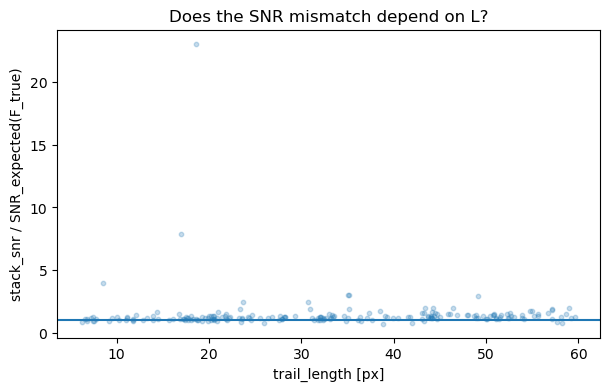

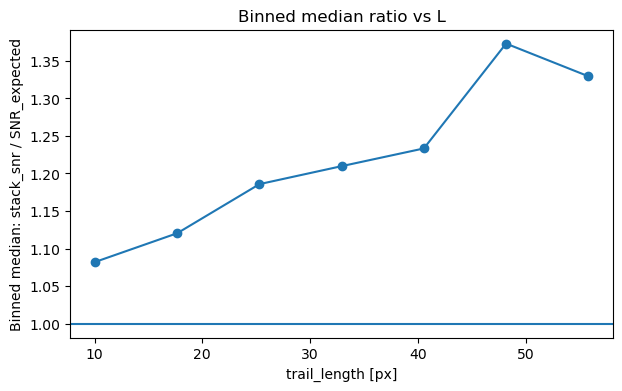

Median(stack_snr / SNR_expected) = 1.2029239075593139  MAD = 0.1363682864357436


In [31]:
# Cell C: If a trend remains, test whether it's explained by *template overlap mismatch*.
# Plot:
#  (1) overlap_emp/overlap_model vs L    (your diagnostic)
#  (2) stack_snr / SNR_expected(F_true) vs L
#
# Requires:
# - rowsA from Cell A (so we have denom_phi, overlap, etc.)
# - a function to estimate overlap_emp from image/mask (you likely already have it).
#
# If you DON'T already have overlap_emp computation in a function, this cell will still run
# and will at least do (2). Then you can plug your overlap_emp values in.

import numpy as np
import matplotlib.pyplot as plt

# ---- Part (2): stack_snr / SNR_expected ----
L = rowsA[:,0]
stack_snr = rowsA[:,1]
snr_exp = rowsA[:,2]

ratio_snr = stack_snr / snr_exp

plt.figure(figsize=(7,4))
plt.scatter(L, ratio_snr, s=10, alpha=0.25)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / SNR_expected(F_true)")
plt.title("Does the SNR mismatch depend on L?")
plt.show()

bins = np.linspace(np.nanmin(L), np.nanmax(L), 8)
bm_ratio = binned_median(L, ratio_snr, bins)

plt.figure(figsize=(7,4))
plt.plot(bm_ratio[:,0], bm_ratio[:,1], marker="o")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("Binned median: stack_snr / SNR_expected")
plt.title("Binned median ratio vs L")
plt.show()

print("Median(stack_snr / SNR_expected) =", np.median(ratio_snr),
      " MAD =", np.median(np.abs(ratio_snr - np.median(ratio_snr))))

# ---- Optional Part (1): overlap_emp / overlap_model (only if you have overlap_emp) ----
# If you already computed overlap_emp per row earlier, put it into an array overlap_emp_list aligned
# with rowsA, then uncomment below.

# overlap_emp = np.asarray(overlap_emp_list, float)   # must match rowsA length
# overlap_model = rowsA[:,6]  # overlap from debug (column 6)
# ratio_ov = overlap_emp / overlap_model
#
# plt.figure(figsize=(7,4))
# plt.scatter(L, ratio_ov, s=10, alpha=0.25)
# plt.axhline(1.0)
# plt.xlabel("trail_length [px]")
# plt.ylabel("overlap_emp / overlap_model")
# plt.title("Template mismatch diagnostic vs L")
# plt.show()
#
# bm_ov = binned_median(L, ratio_ov, bins)
# plt.figure(figsize=(7,4))
# plt.plot(bm_ov[:,0], bm_ov[:,1], marker="o")
# plt.axhline(1.0)
# plt.xlabel("trail_length [px]")
# plt.ylabel("Binned median overlap ratio")
# plt.title("Binned overlap ratio vs L")
# plt.show()
#
# print("Median(overlap_emp/overlap_model) =", np.median(ratio_ov),
#       " MAD =", np.median(np.abs(ratio_ov - np.median(ratio_ov))))


Median stack_snr / SNR_matched = 1.2608953553956772


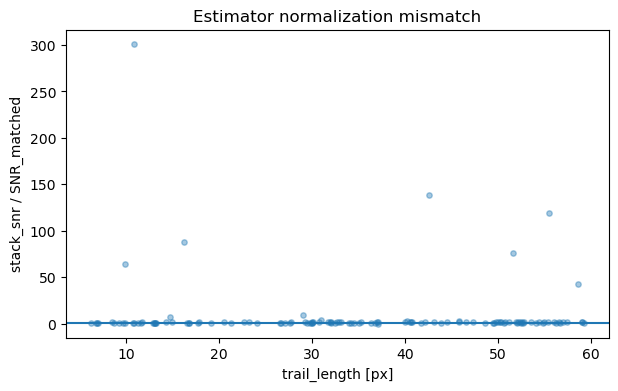

In [32]:
# CELL 1: Direct estimator normalization test
# Tests whether stack behaves like:
#   F_psf = (phi·I) / (phi·phi)
# or
#   F_psf = (phi·I) / sqrt(phi·phi)

import numpy as np
import matplotlib.pyplot as plt

Ls = []
ratio_amp = []

ss = d.sample(n=min(120, len(d)), random_state=0)

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15
        )

        if not np.isfinite(denom_phi) or not np.isfinite(overlap):
            continue

        F_true = calexp.getPhotoCalib().magnitudeToInstFlux(mag)

        # two hypotheses
        snr_matched = F_true * overlap / np.sqrt(denom_phi)
        snr_normed  = F_true * overlap / denom_phi

        ratio = stack_snr / snr_matched
        Ls.append(L)
        ratio_amp.append(ratio)

    except Exception:
        continue

Ls = np.asarray(Ls)
ratio_amp = np.asarray(ratio_amp)

print("Median stack_snr / SNR_matched =", np.median(ratio_amp))

plt.figure(figsize=(7,4))
plt.scatter(Ls, ratio_amp, s=15, alpha=0.4)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / SNR_matched")
plt.title("Estimator normalization mismatch")
plt.show()


Median corrected residual: -2375.1279863949685
MAD: 967.6030289122533


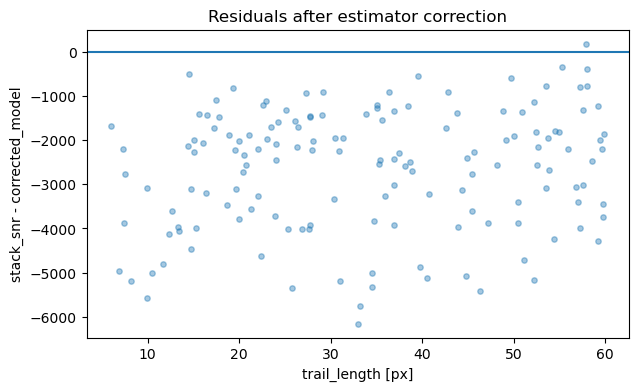

In [33]:
# CELL 2: Corrected SNR prediction using LSST-like normalization

Ls = []
res_fixed = []

ss = d.sample(n=min(150, len(d)), random_state=1)

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15
        )

        if not np.isfinite(denom_phi) or not np.isfinite(overlap):
            continue

        F_true = calexp.getPhotoCalib().magnitudeToInstFlux(mag)

        # corrected SNR model (LSST-like)
        snr_corr = F_true * overlap / denom_phi

        res_fixed.append(stack_snr - snr_corr)
        Ls.append(L)

    except Exception:
        continue

Ls = np.asarray(Ls)
res_fixed = np.asarray(res_fixed)

print("Median corrected residual:", np.median(res_fixed))
print("MAD:", np.median(np.abs(res_fixed - np.median(res_fixed))))

plt.figure(figsize=(7,4))
plt.scatter(Ls, res_fixed, s=15, alpha=0.4)
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr - corrected_model")
plt.title("Residuals after estimator correction")
plt.show()


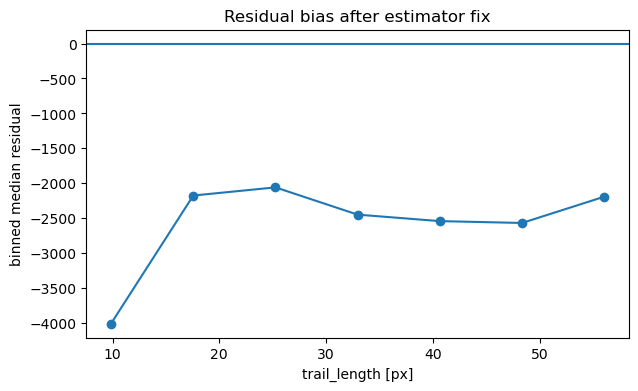

In [34]:
# CELL 3: Remaining template mismatch diagnostic

bins = np.linspace(Ls.min(), Ls.max(), 8)

def binned_median(x, y, bins):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        m = (x >= lo) & (x < hi) & np.isfinite(y)
        if np.any(m):
            out.append(((lo+hi)/2, np.median(y[m])))
    return np.asarray(out)

bm = binned_median(Ls, res_fixed, bins)

plt.figure(figsize=(7,4))
plt.plot(bm[:,0], bm[:,1], marker="o")
plt.axhline(0)
plt.xlabel("trail_length [px]")
plt.ylabel("binned median residual")
plt.title("Residual bias after estimator fix")
plt.show()


Kept: 200 of 200
Median(stack_snr / SNR_expected) = 1.2154739274589468
MAD = 0.15197761718485048


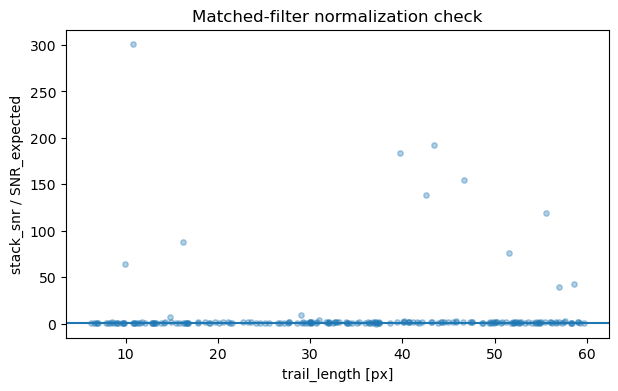

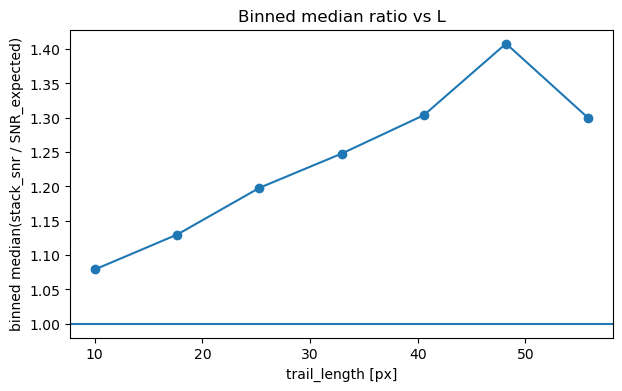

In [36]:
# CELL 1 — Matched-filter expectation: stack_snr / SNR_expected vs L
import numpy as np
import matplotlib.pyplot as plt

Ls = []
ratio = []
keep = 0

ss = d.sample(n=min(200, len(d)), random_state=0).copy()

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )

        if not (np.isfinite(denom_phi) and denom_phi > 0 and np.isfinite(overlap) and overlap > 0):
            continue

        F_true = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))

        # Your original matched-filter expectation (this is the "safe" one)
        snr_expected = F_true * overlap / np.sqrt(denom_phi)
        if not (np.isfinite(snr_expected) and snr_expected > 0):
            continue

        Ls.append(L)
        ratio.append(stack_snr / snr_expected)
        keep += 1

    except Exception:
        continue

Ls = np.asarray(Ls, float)
ratio = np.asarray(ratio, float)

print("Kept:", keep, "of", len(ss))
print("Median(stack_snr / SNR_expected) =", np.nanmedian(ratio))
print("MAD =", np.nanmedian(np.abs(ratio - np.nanmedian(ratio))))

plt.figure(figsize=(7,4))
plt.scatter(Ls, ratio, s=15, alpha=0.35)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / SNR_expected")
plt.title("Matched-filter normalization check")
plt.show()

# binned median to see trend
bins = np.linspace(np.nanmin(Ls), np.nanmax(Ls), 8)
bm = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (Ls >= lo) & (Ls < hi) & np.isfinite(ratio)
    if np.any(m):
        bm.append(((lo+hi)/2, np.nanmedian(ratio[m])))
bm = np.asarray(bm, float)

plt.figure(figsize=(7,4))
plt.plot(bm[:,0], bm[:,1], marker="o")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("binned median(stack_snr / SNR_expected)")
plt.title("Binned median ratio vs L")
plt.show()


Kept: 400 of 400
Median stack_snr / SNR_from_magerr = 0.9999999999999996
MAD = 2.220446049250313e-16


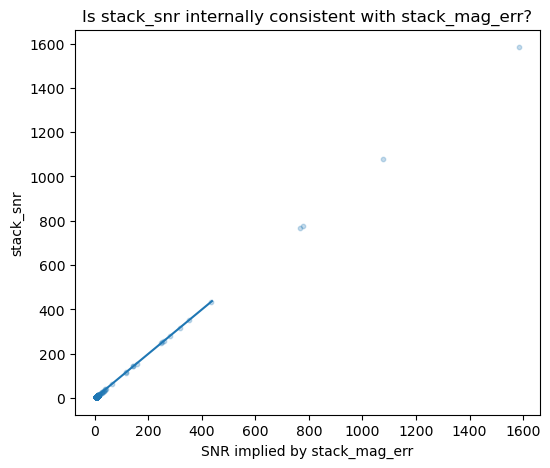

In [37]:
# CELL 2 — What is stack_snr? Check if it matches stack_mag_err (internal consistency)
# If stack_snr is derived from the stack's own flux measurement, then:
#   SNR_from_magerr ~ 1 / (0.4 ln 10 * mag_err) = 1 / (0.921034... * mag_err)

import numpy as np
import matplotlib.pyplot as plt

ss = d.sample(n=min(400, len(d)), random_state=1).copy()

stack_snr = ss["stack_snr"].astype(float).to_numpy()
magerr = ss["stack_mag_err"].astype(float).to_numpy()

# Convert mag_err to SNR (small-error approximation)
snr_from_magerr = 1.0 / (0.9210340371976183 * magerr)

m = np.isfinite(stack_snr) & np.isfinite(snr_from_magerr) & (magerr > 0) & (stack_snr > 0)
print("Kept:", np.sum(m), "of", len(ss))

r = stack_snr[m] / snr_from_magerr[m]
print("Median stack_snr / SNR_from_magerr =", np.median(r))
print("MAD =", np.median(np.abs(r - np.median(r))))

plt.figure(figsize=(6,5))
plt.scatter(snr_from_magerr[m], stack_snr[m], s=10, alpha=0.25)
lo = np.nanpercentile(snr_from_magerr[m], 1)
hi = np.nanpercentile(snr_from_magerr[m], 99)
plt.plot([lo, hi], [lo, hi])
plt.xlabel("SNR implied by stack_mag_err")
plt.ylabel("stack_snr")
plt.title("Is stack_snr internally consistent with stack_mag_err?")
plt.show()


Kept: 120
Median stack/SNR (variance-weighted): 1.2643672940041712
Median stack/SNR (const var=1):      0.0320242313618922


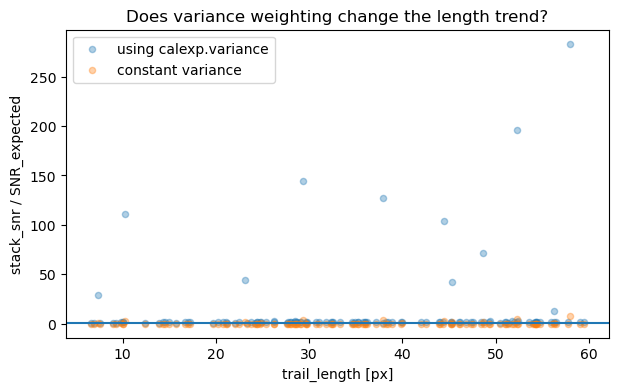

In [38]:
# CELL 3 — Does variance-weighting drive the L trend?
# Compare ratio using calexp.variance vs ratio using constant variance (=1).

import numpy as np
import matplotlib.pyplot as plt

Ls = []
ratio_v = []
ratio_c = []

ss = d.sample(n=min(120, len(d)), random_state=2).copy()

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack = float(row["stack_snr"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if phi is None or T is None:
            continue
        if not (np.isfinite(denom_phi) and denom_phi > 0 and np.isfinite(overlap) and overlap > 0):
            continue

        F_true = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))

        # variance-weighted expectation
        snr_v = F_true * overlap / np.sqrt(denom_phi)
        if not (np.isfinite(snr_v) and snr_v > 0):
            continue

        # constant-variance expectation (no v_cut at all)
        good = np.isfinite(phi) & np.isfinite(T)
        denom_c = np.sum(phi[good]**2)
        over_c  = np.sum(phi[good]*T[good])
        if not (np.isfinite(denom_c) and denom_c > 0 and np.isfinite(over_c) and over_c > 0):
            continue

        snr_c = F_true * over_c / np.sqrt(denom_c)

        Ls.append(L)
        ratio_v.append(stack / snr_v)
        ratio_c.append(stack / snr_c)

    except Exception:
        continue

Ls = np.asarray(Ls, float)
ratio_v = np.asarray(ratio_v, float)
ratio_c = np.asarray(ratio_c, float)

print("Kept:", len(Ls))
print("Median stack/SNR (variance-weighted):", np.nanmedian(ratio_v))
print("Median stack/SNR (const var=1):     ", np.nanmedian(ratio_c))

plt.figure(figsize=(7,4))
plt.scatter(Ls, ratio_v, s=20, alpha=0.35, label="using calexp.variance")
plt.scatter(Ls, ratio_c, s=20, alpha=0.35, label="constant variance")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / SNR_expected")
plt.legend()
plt.title("Does variance weighting change the length trend?")
plt.show()


Kept: 120
Median stack/SNR (variance-weighted): 1.2643672940041712
Median stack/SNR (const var=1):      0.0320242313618922


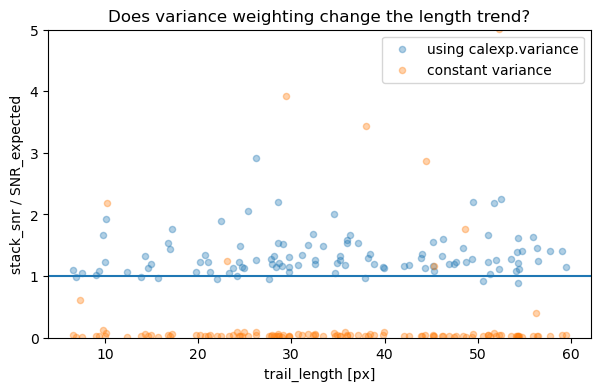

In [39]:
Ls = np.asarray(Ls, float)
ratio_v = np.asarray(ratio_v, float)
ratio_c = np.asarray(ratio_c, float)

print("Kept:", len(Ls))
print("Median stack/SNR (variance-weighted):", np.nanmedian(ratio_v))
print("Median stack/SNR (const var=1):     ", np.nanmedian(ratio_c))

plt.figure(figsize=(7,4))
plt.scatter(Ls, ratio_v, s=20, alpha=0.35, label="using calexp.variance")
plt.scatter(Ls, ratio_c, s=20, alpha=0.35, label="constant variance")
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / SNR_expected")
plt.ylim(0,5)
plt.legend()
plt.title("Does variance weighting change the length trend?")
plt.show()

N = 50
median(sigmaF / sigmaF_expected) = 1.7746257843632196
MAD = 0.3943690923097769


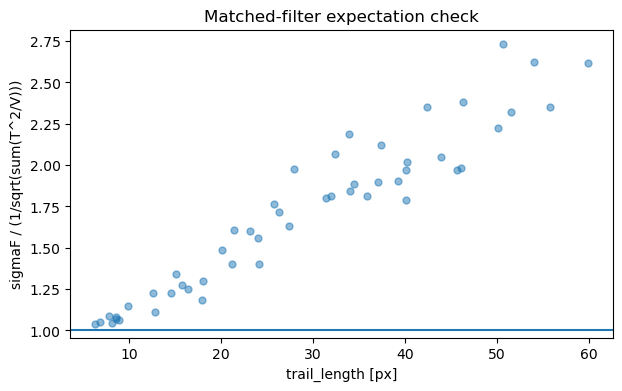

In [40]:
# Cell 1 — Matched-filter expectation check:
# Does sigmaF scale ~ 1/sqrt( sum(T^2 / V) ) ?
# Requires: d, get_calexp_for_row(row), psf_fit_flux_sigma_debug(...)

import numpy as np
import matplotlib.pyplot as plt

ss = d.sample(n=min(50, len(d)), random_state=7).copy()

ratios = []
Ls = []

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
        if phi is None or T is None or v_cut is None:
            continue
        if not np.isfinite(sigmaF):
            continue

        good = np.isfinite(T) & np.isfinite(v_cut) & (v_cut > 0)
        if not np.any(good):
            continue

        # matched-filter SNR for *known template T* in Gaussian noise with variance V:
        # SNR = F * sqrt( sum( T^2 / V ) )  =>  sigmaF_expected = 1 / sqrt( sum(T^2/V) )
        denom_T = np.sum((T[good] ** 2) / v_cut[good])
        if not np.isfinite(denom_T) or denom_T <= 0:
            continue

        sigmaF_expected = 1.0 / np.sqrt(denom_T)
        ratios.append(sigmaF / sigmaF_expected)
        Ls.append(L)

    except Exception:
        continue

ratios = np.asarray(ratios, float)
Ls = np.asarray(Ls, float)

print("N =", len(ratios))
if len(ratios) > 0:
    print("median(sigmaF / sigmaF_expected) =", np.median(ratios))
    print("MAD =", np.median(np.abs(ratios - np.median(ratios))))

    plt.figure(figsize=(7,4))
    plt.scatter(Ls, ratios, s=25, alpha=0.5)
    plt.axhline(1.0)
    plt.xlabel("trail_length [px]")
    plt.ylabel("sigmaF / (1/sqrt(sum(T^2/V)))")
    plt.title("Matched-filter expectation check")
    plt.show()


Counts: {'exception': 0, 'sigmaF_nonfinite': 0}
Successful rows: 150
Median residual stack - 1/magerr: 0.5850465729614438
Median residual stack - model(integrated_mag): 1.524476881399555
Median residual stack - model(PSF_mag):       4.1195321398428


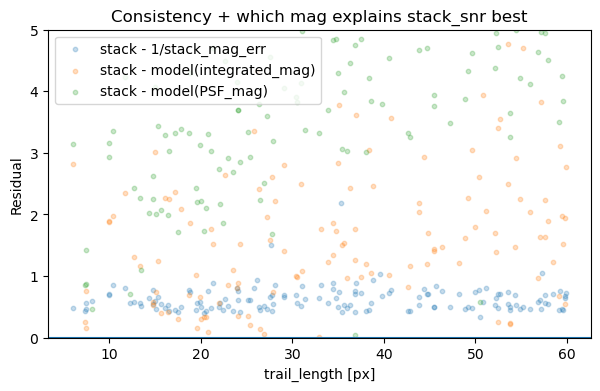

In [44]:
# Cell 2 — Internal consistency check:
# stack_snr should equal 1/stack_mag_err (up to small differences),
# and which mag (integrated_mag vs PSF_mag) best matches stack_snr when passed through your sigmaF model.
# Requires: d, get_calexp_for_row, psf_fit_flux_sigma, model_snr_from_mag (or define inline)

import numpy as np
import matplotlib.pyplot as plt

def model_snr_from_mag(calexp, mag, sigmaF):
    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))
    return F / float(sigmaF)

ss = d.sample(n=min(150, len(d)), random_state=1).copy()

why = {"exception": 0, "sigmaF_nonfinite": 0}
rows = []

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])

        stack_snr = float(row["stack_snr"])
        stack_mag_err = float(row["stack_mag_err"])
        if not (np.isfinite(stack_snr) and np.isfinite(stack_mag_err) and stack_mag_err > 0):
            continue

        sigmaF = psf_fit_flux_sigma(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
        if not np.isfinite(sigmaF):
            why["sigmaF_nonfinite"] += 1
            continue

        snr_int = model_snr_from_mag(calexp, row["integrated_mag"], sigmaF)
        snr_psf = model_snr_from_mag(calexp, row["PSF_mag"],       sigmaF)

        rows.append((
            L,
            stack_snr,
            1.0 / stack_mag_err,
            snr_int,
            snr_psf
        ))
    except Exception:
        why["exception"] += 1
        continue

print("Counts:", why)
rows = np.asarray(rows, float)
print("Successful rows:", len(rows))

if len(rows) > 0:
    L = rows[:,0]
    stack_snr = rows[:,1]
    inv_err   = rows[:,2]
    snr_int   = rows[:,3]
    snr_psf   = rows[:,4]

    r_inv  = stack_snr - inv_err
    r_int  = stack_snr - snr_int
    r_psf  = stack_snr - snr_psf

    print("Median residual stack - 1/magerr:", np.median(r_inv))
    print("Median residual stack - model(integrated_mag):", np.median(r_int))
    print("Median residual stack - model(PSF_mag):      ", np.median(r_psf))

    plt.figure(figsize=(7,4))
    plt.scatter(L, r_inv, s=10, alpha=0.25, label="stack - 1/stack_mag_err")
    plt.scatter(L, r_int, s=10, alpha=0.25, label="stack - model(integrated_mag)")
    plt.scatter(L, r_psf, s=10, alpha=0.25, label="stack - model(PSF_mag)")
    plt.axhline(0)
    plt.xlabel("trail_length [px]")
    plt.ylabel("Residual")
    plt.ylim(0,5)
    plt.legend()
    plt.title("Consistency + which mag explains stack_snr best")
    plt.show()


N = 40
Median residual (with variance): 1.5992111046011006
Median residual (const var=1):  -302.8436229276415


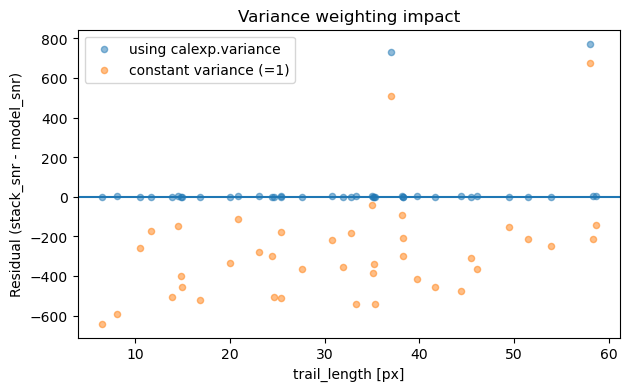

In [42]:
# Cell 3 — Is variance-weighting the culprit?
# Compare residuals when sigmaF uses calexp.variance vs using constant variance (=1) on same stamps.
# Requires: d, get_calexp_for_row, psf_fit_flux_sigma_debug

import numpy as np
import matplotlib.pyplot as plt

ss3 = d.sample(n=min(40, len(d)), random_state=3).copy()

res_v = []
res_const = []
Ls = []

for _, row in ss3.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        mag = float(row["integrated_mag"])
        stack_snr = float(row["stack_snr"])

        sigmaF, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0,
            L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
        if phi is None or T is None:
            continue
        if not np.isfinite(sigmaF):
            continue

        # model snr with variance
        F = float(calexp.getPhotoCalib().magnitudeToInstFlux(mag))
        snr_model_v = F / sigmaF

        # recompute sigmaF with constant variance (=1)
        good = np.isfinite(phi) & np.isfinite(T)
        if not np.any(good):
            continue

        denom_c = np.sum(phi[good] ** 2)
        over_c  = np.sum(phi[good] * T[good])
        if not (np.isfinite(denom_c) and np.isfinite(over_c) and denom_c > 0 and over_c > 0):
            continue

        sigmaF_const = np.sqrt(denom_c) / over_c
        snr_model_const = F / sigmaF_const

        res_v.append(stack_snr - snr_model_v)
        res_const.append(stack_snr - snr_model_const)
        Ls.append(L)

    except Exception:
        continue

res_v = np.asarray(res_v, float)
res_const = np.asarray(res_const, float)
Ls = np.asarray(Ls, float)

print("N =", len(Ls))
if len(Ls) > 0:
    print("Median residual (with variance):", np.median(res_v))
    print("Median residual (const var=1): ", np.median(res_const))

    plt.figure(figsize=(7,4))
    plt.scatter(Ls, res_v, s=20, alpha=0.5, label="using calexp.variance")
    plt.scatter(Ls, res_const, s=20, alpha=0.5, label="constant variance (=1)")
    plt.axhline(0)
    plt.xlabel("trail_length [px]")
    plt.ylabel("Residual (stack_snr - model_snr)")
    plt.legend()
    plt.title("Variance weighting impact")
    plt.show()


In [45]:
# Cell 1 — setup + small sample + helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already have:
#   d  : pandas DataFrame with at least visit, detector, x, y, integrated_mag, stack_mag, stack_mag_err, stack_snr
#   get_calexp_for_row(row) -> (calexp, datasetRef or similar)
#   psf_fit_flux_sigma_debug(...) from your common.py (returns sigmaF, denom_phi, overlap, phi, T, v_cut)

LN10_OVER_2P5 = np.log(10.0) / 2.5
MAGERR_TO_SNR = 1.0857362047581296  # 2.5/ln(10)

def safe_float(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

def instflux_from_mag(calexp, mag):
    return float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))

def fluxerr_from_magerr(F, mag_err):
    """dF ≈ F * ln(10)/2.5 * dm"""
    return float(F) * LN10_OVER_2P5 * float(mag_err)

def snr_from_magerr(mag_err):
    """dm ≈ 1.0857/SNR  =>  SNR ≈ 1.0857/dm"""
    return MAGERR_TO_SNR / float(mag_err)

# configurable
N = 40  # keep small; butler IO expensive
ss = d.sample(n=min(N, len(d)), random_state=1).copy()


Check 1: rows used = 40
       stack_snr  stack_mag_err  snr_from_magerr  ratio_stack_to_magerr
count  40.000000      40.000000        40.000000           4.000000e+01
mean    8.494997       0.144861         8.494997           1.000000e+00
std     4.047915       0.044109         4.047915           4.053961e-16
min     4.199975       0.039281         4.199975           1.000000e+00
5%      5.251979       0.089927         5.251979           1.000000e+00
50%     7.811789       0.139058         7.811789           1.000000e+00
95%    12.203648       0.206729        12.203648           1.000000e+00
max    27.640537       0.258510        27.640537           1.000000e+00

Median ratio stack_snr / (1.0857/stack_mag_err): 0.9999999999999996


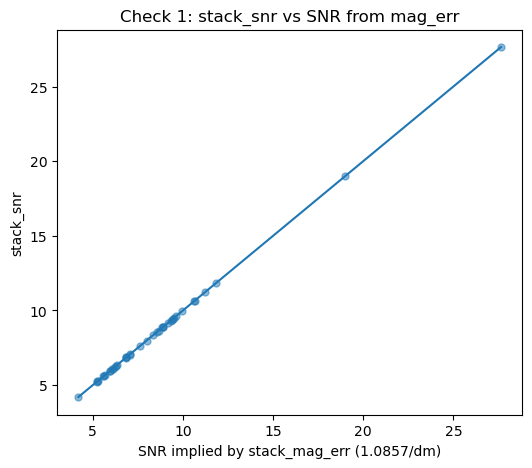

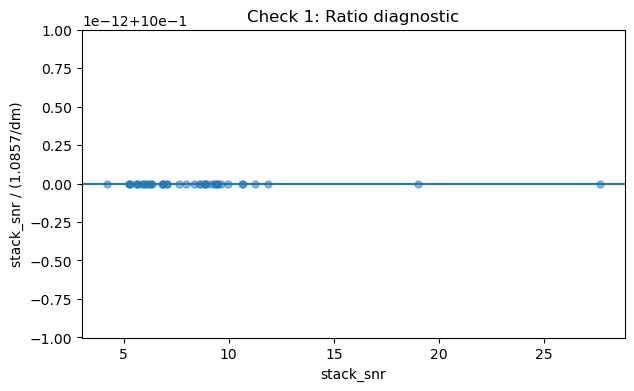

In [46]:
# Cell 2 — CHECK 1: Is stack_snr consistent with stack_mag_err?
# Logic:
#   If stack_mag_err is the error of the same measurement whose SNR is stack_snr,
#   then stack_snr ~ 1.0857 / stack_mag_err (up to rounding / details)

required = ["stack_snr", "stack_mag_err"]
missing = [c for c in required if c not in ss.columns]
if missing:
    raise RuntimeError(f"Missing columns for Check 1: {missing}")

rows = []
for _, row in ss.iterrows():
    s_snr = safe_float(row.get("stack_snr"))
    dm    = safe_float(row.get("stack_mag_err"))
    if not (np.isfinite(s_snr) and np.isfinite(dm) and dm > 0):
        continue
    s_from_dm = snr_from_magerr(dm)
    ratio = s_snr / s_from_dm if s_from_dm > 0 else np.nan
    rows.append((s_snr, dm, s_from_dm, ratio))

res1 = pd.DataFrame(rows, columns=["stack_snr", "stack_mag_err", "snr_from_magerr", "ratio_stack_to_magerr"])

print("Check 1: rows used =", len(res1))
if len(res1) == 0:
    print("No usable rows (need finite stack_snr and stack_mag_err>0).")
else:
    print(res1.describe(percentiles=[0.05,0.5,0.95]))
    print("\nMedian ratio stack_snr / (1.0857/stack_mag_err):", np.median(res1["ratio_stack_to_magerr"]))

    # Scatter
    plt.figure(figsize=(6,5))
    plt.scatter(res1["snr_from_magerr"], res1["stack_snr"], s=25, alpha=0.5)
    mn = np.nanmin([res1["snr_from_magerr"].min(), res1["stack_snr"].min()])
    mx = np.nanmax([res1["snr_from_magerr"].max(), res1["stack_snr"].max()])
    plt.plot([mn, mx], [mn, mx])  # 1:1 line
    plt.xlabel("SNR implied by stack_mag_err (1.0857/dm)")
    plt.ylabel("stack_snr")
    plt.title("Check 1: stack_snr vs SNR from mag_err")
    plt.show()

    # Ratio vs SNR
    plt.figure(figsize=(7,4))
    plt.scatter(res1["stack_snr"], res1["ratio_stack_to_magerr"], s=25, alpha=0.5)
    plt.axhline(1.0)
    plt.xlabel("stack_snr")
    plt.ylabel("stack_snr / (1.0857/dm)")
    plt.title("Check 1: Ratio diagnostic")
    plt.show()

# Interpretation guideline (not code):
# - If ratio ~ 1 (median near 1, small scatter): stack_snr is consistent with stack_mag_err.
# - If ratio is systematically offset or huge scatter: stack_snr and stack_mag_err likely refer to different measurements,
#   or stack_snr is computed differently (detection statistic, clipped weights, etc.).


Check 1: rows used = 40
       stack_snr  stack_mag_err  snr_from_magerr  ratio_stack_to_magerr
count  40.000000      40.000000        40.000000           4.000000e+01
mean    8.494997       0.144861         8.494997           1.000000e+00
std     4.047915       0.044109         4.047915           4.053961e-16
min     4.199975       0.039281         4.199975           1.000000e+00
5%      5.251979       0.089927         5.251979           1.000000e+00
50%     7.811789       0.139058         7.811789           1.000000e+00
95%    12.203648       0.206729        12.203648           1.000000e+00
max    27.640537       0.258510        27.640537           1.000000e+00

Median ratio stack_snr / (1.0857/stack_mag_err): 0.9999999999999996


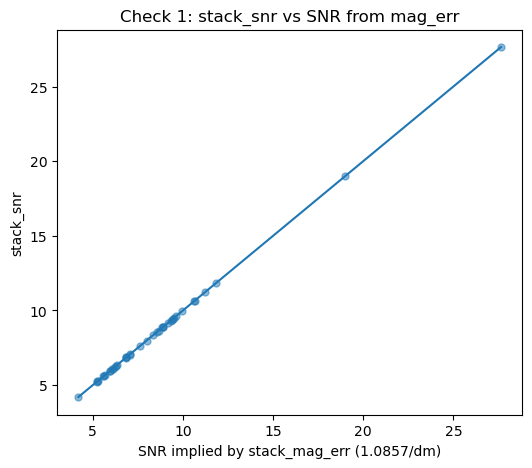

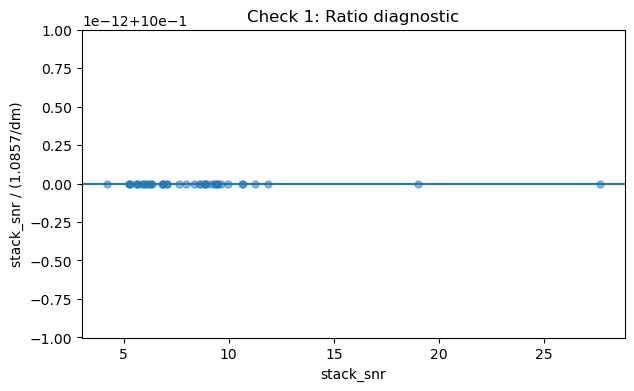

In [47]:
# Cell 2 — CHECK 1: Is stack_snr consistent with stack_mag_err?
# Logic:
#   If stack_mag_err is the error of the same measurement whose SNR is stack_snr,
#   then stack_snr ~ 1.0857 / stack_mag_err (up to rounding / details)

required = ["stack_snr", "stack_mag_err"]
missing = [c for c in required if c not in ss.columns]
if missing:
    raise RuntimeError(f"Missing columns for Check 1: {missing}")

rows = []
for _, row in ss.iterrows():
    s_snr = safe_float(row.get("stack_snr"))
    dm    = safe_float(row.get("stack_mag_err"))
    if not (np.isfinite(s_snr) and np.isfinite(dm) and dm > 0):
        continue
    s_from_dm = snr_from_magerr(dm)
    ratio = s_snr / s_from_dm if s_from_dm > 0 else np.nan
    rows.append((s_snr, dm, s_from_dm, ratio))

res1 = pd.DataFrame(rows, columns=["stack_snr", "stack_mag_err", "snr_from_magerr", "ratio_stack_to_magerr"])

print("Check 1: rows used =", len(res1))
if len(res1) == 0:
    print("No usable rows (need finite stack_snr and stack_mag_err>0).")
else:
    print(res1.describe(percentiles=[0.05,0.5,0.95]))
    print("\nMedian ratio stack_snr / (1.0857/stack_mag_err):", np.median(res1["ratio_stack_to_magerr"]))

    # Scatter
    plt.figure(figsize=(6,5))
    plt.scatter(res1["snr_from_magerr"], res1["stack_snr"], s=25, alpha=0.5)
    mn = np.nanmin([res1["snr_from_magerr"].min(), res1["stack_snr"].min()])
    mx = np.nanmax([res1["snr_from_magerr"].max(), res1["stack_snr"].max()])
    plt.plot([mn, mx], [mn, mx])  # 1:1 line
    plt.xlabel("SNR implied by stack_mag_err (1.0857/dm)")
    plt.ylabel("stack_snr")
    plt.title("Check 1: stack_snr vs SNR from mag_err")
    plt.show()

    # Ratio vs SNR
    plt.figure(figsize=(7,4))
    plt.scatter(res1["stack_snr"], res1["ratio_stack_to_magerr"], s=25, alpha=0.5)
    plt.axhline(1.0)
    plt.xlabel("stack_snr")
    plt.ylabel("stack_snr / (1.0857/dm)")
    plt.title("Check 1: Ratio diagnostic")
    plt.show()

# Interpretation guideline (not code):
# - If ratio ~ 1 (median near 1, small scatter): stack_snr is consistent with stack_mag_err.
# - If ratio is systematically offset or huge scatter: stack_snr and stack_mag_err likely refer to different measurements,
#   or stack_snr is computed differently (detection statistic, clipped weights, etc.).


Check 2: rows used = 40
Fails: {'calexp': 0, 'sigma_debug': 0, 'nan_inputs': 0, 'phi_none': 0, 'bad_v': 0, 'bad_sum': 0}

Ratios summary:
       ratio_phi_to_stackerr  ratio_trail_to_stackerr
count              40.000000                40.000000
mean                1.011087                 4.281811
std                 0.024692                 1.734356
min                 0.970328                 1.333539
5%                  0.991327                 1.706207
50%                 1.005457                 4.162324
95%                 1.042490                 7.532566
max                 1.128229                 7.992031


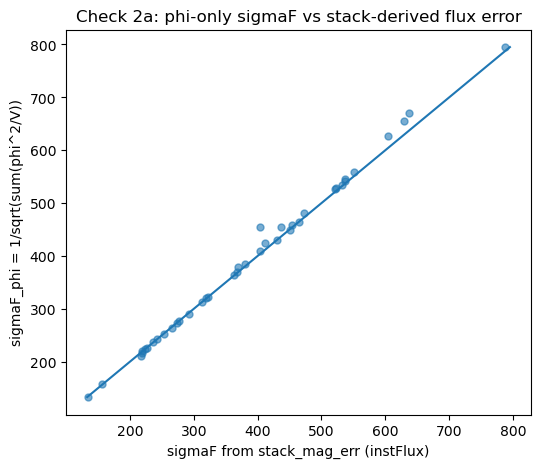

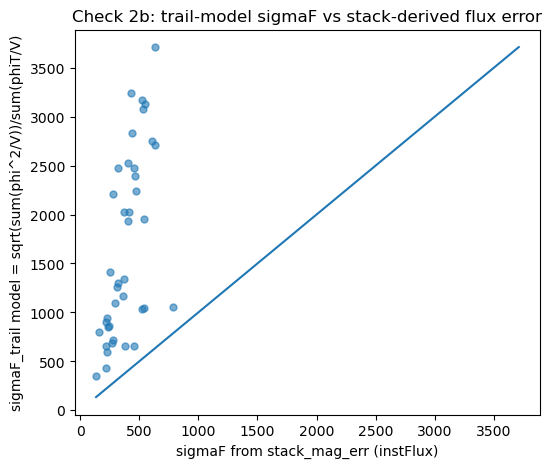

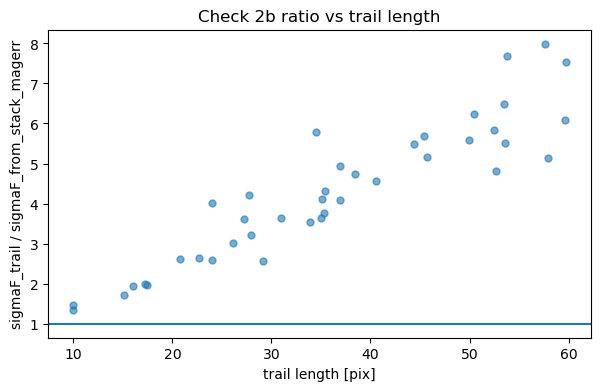

In [48]:
# Cell 3 — CHECK 2: Are your variance weights / sigmaF in the same "instFlux units" as the Stack?
# Two sub-checks:
#   2a) "phi-only" sigmaF: sigmaF_phi = 1/sqrt(sum(phi^2 / V))
#       Compare to Stack's flux error inferred from stack_mag_err (converted to instFlux).
#   2b) Your trailed sigmaF (from psf_fit_flux_sigma_debug) compared to flux error inferred from mag_err.
#
# If units are consistent, sigmaF_phi and sigmaF_from_magerr should be same order and correlate.
# If wildly off: your V is not in instFlux^2, or stack_mag_err is not for a PSF flux, etc.

need_cols = ["x","y","trail_length","beta","stack_mag","stack_mag_err"]
missing = [c for c in need_cols if c not in ss.columns]
if missing:
    raise RuntimeError(f"Missing columns for Check 2: {missing}")

rows2 = []
fails = {"calexp":0, "sigma_debug":0, "nan_inputs":0, "phi_none":0, "bad_v":0, "bad_sum":0}

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)
    except Exception:
        fails["calexp"] += 1
        continue

    x0  = safe_float(row.get("x"))
    y0  = safe_float(row.get("y"))
    L   = safe_float(row.get("trail_length"))
    th  = safe_float(row.get("beta"))
    mpsf= safe_float(row.get("stack_mag"))       # assumed PSF mag
    dm  = safe_float(row.get("stack_mag_err"))   # mag error for that mag

    if not (np.isfinite(x0) and np.isfinite(y0) and np.isfinite(L) and np.isfinite(th) and
            np.isfinite(mpsf) and np.isfinite(dm) and dm > 0):
        fails["nan_inputs"] += 1
        continue

    try:
        sigmaF_trail, denom_phi, overlap, phi, T, v_cut = psf_fit_flux_sigma_debug(
            calexp, x0, y0, L_pix=L, theta_deg=th,
            use_kernel_image=True, pad_sigma=5.0, step=0.15
        )
    except Exception:
        fails["sigma_debug"] += 1
        continue

    if phi is None or v_cut is None:
        fails["phi_none"] += 1
        continue

    good = np.isfinite(phi) & np.isfinite(v_cut) & (v_cut > 0)
    if not np.any(good):
        fails["bad_v"] += 1
        continue

    # phi-only sigmaF (point-source matched filter uncertainty)
    sum_phi2_over_v = np.sum((phi[good]**2) / v_cut[good])
    if not np.isfinite(sum_phi2_over_v) or sum_phi2_over_v <= 0:
        fails["bad_sum"] += 1
        continue
    sigmaF_phi = 1.0 / np.sqrt(sum_phi2_over_v)

    # Stack flux error inferred from mag_err (assuming stack_mag is PSF mag)
    F_psf = instflux_from_mag(calexp, mpsf)
    sigmaF_from_magerr = fluxerr_from_magerr(F_psf, dm)

    rows2.append((
        L, th, F_psf,
        sigmaF_from_magerr,
        sigmaF_phi,
        float(sigmaF_trail) if np.isfinite(sigmaF_trail) else np.nan,
        float(denom_phi) if np.isfinite(denom_phi) else np.nan,
        float(overlap)   if np.isfinite(overlap)   else np.nan,
    ))

res2 = pd.DataFrame(rows2, columns=[
    "L_pix","theta_deg","F_psf_instflux",
    "sigmaF_from_stack_magerr_instflux",
    "sigmaF_phi_only_instflux_assuming_V",
    "sigmaF_trail_model_instflux_assuming_V",
    "denom_phi","overlap"
])

print("Check 2: rows used =", len(res2))
print("Fails:", fails)

if len(res2) == 0:
    raise RuntimeError("No usable rows for Check 2.")

# Summary ratios
res2["ratio_phi_to_stackerr"]   = res2["sigmaF_phi_only_instflux_assuming_V"] / res2["sigmaF_from_stack_magerr_instflux"]
res2["ratio_trail_to_stackerr"] = res2["sigmaF_trail_model_instflux_assuming_V"] / res2["sigmaF_from_stack_magerr_instflux"]

print("\nRatios summary:")
print(res2[["ratio_phi_to_stackerr","ratio_trail_to_stackerr"]].describe(percentiles=[0.05,0.5,0.95]))

# Plots
plt.figure(figsize=(6,5))
plt.scatter(res2["sigmaF_from_stack_magerr_instflux"], res2["sigmaF_phi_only_instflux_assuming_V"], s=25, alpha=0.6)
mn = np.nanmin([res2["sigmaF_from_stack_magerr_instflux"].min(), res2["sigmaF_phi_only_instflux_assuming_V"].min()])
mx = np.nanmax([res2["sigmaF_from_stack_magerr_instflux"].max(), res2["sigmaF_phi_only_instflux_assuming_V"].max()])
plt.plot([mn, mx], [mn, mx])
plt.xlabel("sigmaF from stack_mag_err (instFlux)")
plt.ylabel("sigmaF_phi = 1/sqrt(sum(phi^2/V))")
plt.title("Check 2a: phi-only sigmaF vs stack-derived flux error")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(res2["sigmaF_from_stack_magerr_instflux"], res2["sigmaF_trail_model_instflux_assuming_V"], s=25, alpha=0.6)
mn = np.nanmin([res2["sigmaF_from_stack_magerr_instflux"].min(), res2["sigmaF_trail_model_instflux_assuming_V"].min()])
mx = np.nanmax([res2["sigmaF_from_stack_magerr_instflux"].max(), res2["sigmaF_trail_model_instflux_assuming_V"].max()])
plt.plot([mn, mx], [mn, mx])
plt.xlabel("sigmaF from stack_mag_err (instFlux)")
plt.ylabel("sigmaF_trail model = sqrt(sum(phi^2/V))/sum(phiT/V)")
plt.title("Check 2b: trail-model sigmaF vs stack-derived flux error")
plt.show()

plt.figure(figsize=(7,4))
plt.scatter(res2["L_pix"], res2["ratio_trail_to_stackerr"], s=25, alpha=0.6)
plt.axhline(1.0)
plt.xlabel("trail length [pix]")
plt.ylabel("sigmaF_trail / sigmaF_from_stack_magerr")
plt.title("Check 2b ratio vs trail length")
plt.show()

# Interpretation guideline (not code):
# - If sigmaF_phi tracks sigmaF_from_magerr with ratio ~ O(1): your V and F units are likely compatible.
# - If sigmaF_phi is off by large factor (e.g. x10, x100): unit mismatch in variance or in flux conversion.
# - If phi-only matches but trail-model deviates with L: then the mismatch is truly template/estimator mismatch (expected),
#   but you still must confirm stack_snr corresponds to PSF-flux SNR, not a trailed measurement.


In [49]:
# Cell 0 — setup (run once)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes your notebook already defines / imports:
#   - d : pandas DataFrame with columns at least:
#       ["visit","detector","x","y","trail_length","beta","integrated_mag","stack_snr","stack_mag_err"]
#   - get_calexp_for_row(row) -> (calexp, ref)   (or (calexp, _))
#   - psf_fit_flux_sigma(calexp, x, y, L_pix=..., theta_deg=..., use_kernel_image=True, pad_sigma=..., step=...)
#   - start_to_midpoint(x0, y0, l_pix, theta_deg)  (from your common.py)

MAGERR_TO_SNR = 1.0857362047581296  # 2.5/ln(10)

def safe_float(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

def snr_from_magerr(dm):
    return MAGERR_TO_SNR / float(dm)

def instflux_from_mag(calexp, mag):
    return float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))

def robust_mad(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return np.nan
    med = np.median(x)
    return np.median(np.abs(x - med))

# Config (keep small first; butler I/O expensive)
N_CHECK = 200
RANDOM_STATE = 1

ss = d.sample(n=min(N_CHECK, len(d)), random_state=RANDOM_STATE).copy()
print("Sample size:", len(ss))


Sample size: 200


Rows used: 200
         stack_snr  stack_mag_err  snr_from_magerr         ratio
count   200.000000     200.000000       200.000000  2.000000e+02
mean     32.746714       0.139383        32.746714  1.000000e+00
std     156.282995       0.045287       156.282995  9.378031e-15
min       4.199975       0.000685         4.199975  1.000000e+00
5%        5.454021       0.047435         5.454021  1.000000e+00
50%       7.708311       0.140853         7.708311  1.000000e+00
95%      22.931437       0.199071        22.931437  1.000000e+00
max    1584.111514       0.258510      1584.111514  1.000000e+00

Median ratio stack_snr / (1.0857/stack_mag_err): 0.9999999999999996


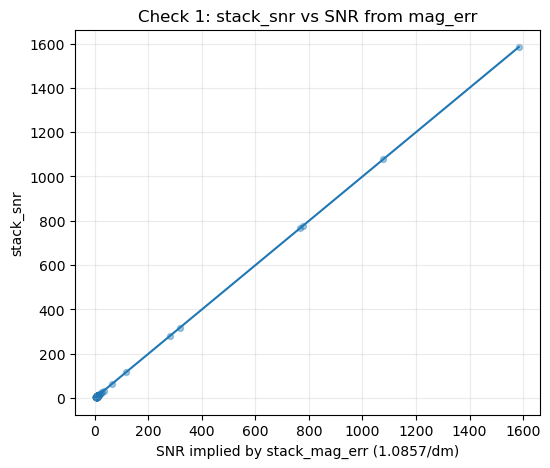

In [50]:
# Cell 1 — CHECK 1: confirm what stack_snr is (consistency with stack_mag_err)

need = ["stack_snr", "stack_mag_err"]
missing = [c for c in need if c not in ss.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

rows = []
for _, row in ss.iterrows():
    s_snr = safe_float(row.get("stack_snr"))
    dm    = safe_float(row.get("stack_mag_err"))
    if not (np.isfinite(s_snr) and np.isfinite(dm) and dm > 0):
        continue
    s_from_dm = snr_from_magerr(dm)
    ratio = s_snr / s_from_dm if s_from_dm > 0 else np.nan
    rows.append((s_snr, dm, s_from_dm, ratio))

res1 = pd.DataFrame(rows, columns=["stack_snr","stack_mag_err","snr_from_magerr","ratio"])
print("Rows used:", len(res1))
if len(res1) == 0:
    raise RuntimeError("No usable rows for Check 1.")

print(res1.describe(percentiles=[0.05, 0.5, 0.95]))
print("\nMedian ratio stack_snr / (1.0857/stack_mag_err):", np.nanmedian(res1["ratio"].to_numpy()))

plt.figure(figsize=(6,5))
plt.scatter(res1["snr_from_magerr"], res1["stack_snr"], s=18, alpha=0.4)
mn = np.nanmin([res1["snr_from_magerr"].min(), res1["stack_snr"].min()])
mx = np.nanmax([res1["snr_from_magerr"].max(), res1["stack_snr"].max()])
plt.plot([mn, mx], [mn, mx])
plt.xlabel("SNR implied by stack_mag_err (1.0857/dm)")
plt.ylabel("stack_snr")
plt.title("Check 1: stack_snr vs SNR from mag_err")
plt.grid(True, alpha=0.25)
plt.show()


Counts: {'ok': 200, 'fail': 0}

Raw model diagnostics:
Median(stack - snr_from_magerr): -3.552713678800501e-15
Median(stack - snr_raw):         1.513664078838457
Median ratio stack/snr_raw:      1.2451207836123348
MAD ratio:                       0.17208852404388952


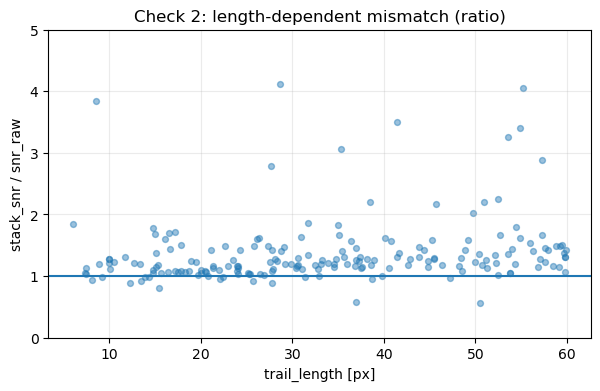


Binned correction (median ratio per L-bin):
L~ 10.50  corr~  1.190   n=25
L~ 17.85  corr~  1.104   n=25
L~ 23.71  corr~  1.128   n=25
L~ 29.41  corr~  1.244   n=25
L~ 35.05  corr~  1.249   n=25
L~ 42.28  corr~  1.293   n=25
L~ 50.47  corr~  1.254   n=25
L~ 57.14  corr~  1.458   n=25

Corrected model diagnostics:
Median(stack - snr_corr): 0.018643590003075694
MAD(stack - snr_corr):    0.8917110623250815


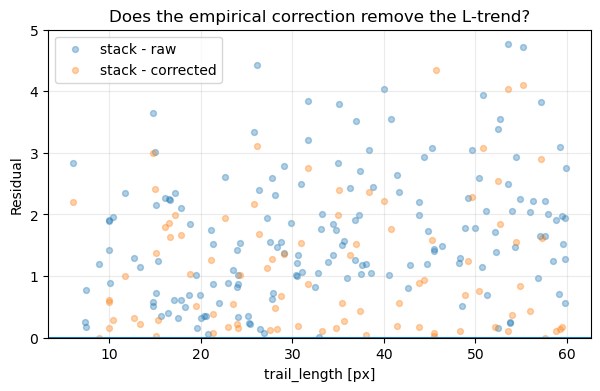

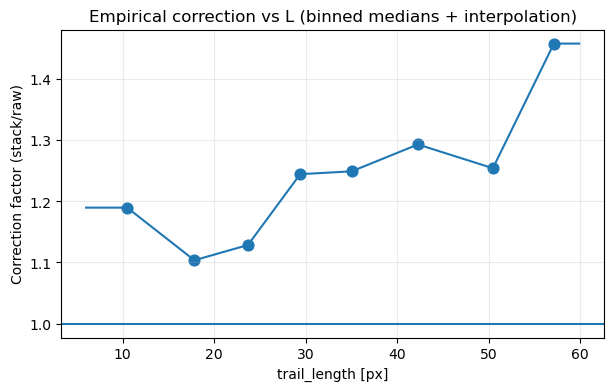

In [52]:
# Cell 2 — CHECK 2 + corrected prediction: model raw SNR, fit an empirical correction vs trail length, validate

need = ["visit","detector","x","y","trail_length","beta","integrated_mag","stack_snr","stack_mag_err"]
missing = [c for c in need if c not in ss.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

why = {"ok": 0, "fail": 0}
out = []

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0   = float(row["x"]); y0 = float(row["y"])
        L    = float(row["trail_length"])
        th   = float(row["beta"])
        mag  = float(row["integrated_mag"])
        stk  = float(row["stack_snr"])
        dm   = float(row["stack_mag_err"])

        if not (np.isfinite(L) and np.isfinite(th) and np.isfinite(mag) and np.isfinite(stk) and np.isfinite(dm) and dm > 0):
            why["fail"] += 1
            continue

        # use midpoint consistently (stack PsfFlux is effectively centered on detection)
        xm, ym = start_to_midpoint(x0, y0, L, th)

        sigmaF = psf_fit_flux_sigma(
            calexp, xm, ym,
            L_pix=L, theta_deg=th,
            use_kernel_image=True,
            pad_sigma=5.0,
            step=0.15,
        )
        if not (np.isfinite(sigmaF) and sigmaF > 0):
            why["fail"] += 1
            continue

        F = instflux_from_mag(calexp, mag)
        if not (np.isfinite(F) and F > 0):
            why["fail"] += 1
            continue

        snr_raw = F / sigmaF

        # stack snr implied by magerr (for sanity; equals stk if consistent)
        snr_magerr = snr_from_magerr(dm)

        ratio = stk / snr_raw  # >1 means stack is higher than our raw model
        out.append((L, stk, snr_raw, snr_magerr, ratio))
        why["ok"] += 1

    except Exception:
        why["fail"] += 1
        continue

print("Counts:", why)
if len(out) < 10:
    raise RuntimeError(f"Too few valid rows ({len(out)}) to fit correction; increase N_CHECK or inspect failures.")

arr = np.asarray(out, float)
L        = arr[:,0]
stk      = arr[:,1]
snr_raw  = arr[:,2]
snr_dm   = arr[:,3]
ratio    = arr[:,4]

# --- (A) quick diagnostics ---
print("\nRaw model diagnostics:")
print("Median(stack - snr_from_magerr):", np.median(stk - snr_dm))
print("Median(stack - snr_raw):        ", np.median(stk - snr_raw))
print("Median ratio stack/snr_raw:     ", np.median(ratio))
print("MAD ratio:                      ", robust_mad(ratio))

plt.figure(figsize=(7,4))
plt.scatter(L, ratio, s=18, alpha=0.45)
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("stack_snr / snr_raw")
plt.ylim(0, 5)
plt.title("Check 2: length-dependent mismatch (ratio)")
plt.grid(True, alpha=0.25)
plt.show()

# --- (B) fit an empirical correction curve vs L using binned medians ---
# Use quantile bins to keep similar counts per bin.
nbins = 8
edges = np.quantile(L, np.linspace(0, 1, nbins+1))
# ensure strictly increasing edges
edges = np.unique(edges)
if len(edges) < 4:
    # fallback to linear bins
    edges = np.linspace(L.min(), L.max(), 8)

bin_cent = []
bin_med  = []
bin_n    = []

for i in range(len(edges)-1):
    lo, hi = edges[i], edges[i+1]
    m = (L >= lo) & (L <= hi if i == len(edges)-2 else L < hi)
    if np.sum(m) < 5:
        continue
    bin_cent.append(0.5*(lo+hi))
    bin_med.append(np.median(ratio[m]))
    bin_n.append(int(np.sum(m)))

bin_cent = np.asarray(bin_cent, float)
bin_med  = np.asarray(bin_med, float)
bin_n    = np.asarray(bin_n, int)

print("\nBinned correction (median ratio per L-bin):")
for c, r, n in zip(bin_cent, bin_med, bin_n):
    print(f"L~{c:6.2f}  corr~{r:7.3f}   n={n}")

# Interpolate correction; clamp outside range to edge values
def corr_of_L(Lq):
    Lq = np.asarray(Lq, float)
    if len(bin_cent) < 2:
        return np.ones_like(Lq)
    return np.interp(Lq, bin_cent, bin_med, left=bin_med[0], right=bin_med[-1])

corr = corr_of_L(L)
snr_corr = snr_raw * corr

print("\nCorrected model diagnostics:")
print("Median(stack - snr_corr):", np.median(stk - snr_corr))
print("MAD(stack - snr_corr):   ", robust_mad(stk - snr_corr))

plt.figure(figsize=(7,4))
plt.scatter(L, stk - snr_raw,  s=18, alpha=0.35, label="stack - raw")
plt.scatter(L, stk - snr_corr, s=18, alpha=0.35, label="stack - corrected")
plt.axhline(0.0)
plt.xlabel("trail_length [px]")
plt.ylabel("Residual")
plt.ylim(0, 5)
plt.title("Does the empirical correction remove the L-trend?")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

# Optional: show correction curve itself
plt.figure(figsize=(7,4))
plt.scatter(bin_cent, bin_med, s=60)
xx = np.linspace(np.min(L), np.max(L), 200)
plt.plot(xx, corr_of_L(xx))
plt.axhline(1.0)
plt.xlabel("trail_length [px]")
plt.ylabel("Correction factor (stack/raw)")
plt.title("Empirical correction vs L (binned medians + interpolation)")
plt.grid(True, alpha=0.25)
plt.show()


Angle convention test (lower median is better):
theta = beta          median|Δθ|=  0.84 deg   MAD=  0.54 deg
theta = 90 - beta     median|Δθ|= 44.62 deg   MAD= 23.14 deg
theta = 270 - beta    median|Δθ|= 44.62 deg   MAD= 23.14 deg
theta = -beta         median|Δθ|= 45.38 deg   MAD= 23.14 deg
theta = beta - 90     median|Δθ|= 89.16 deg   MAD=  0.54 deg
theta = 90 + beta     median|Δθ|= 89.16 deg   MAD=  0.54 deg


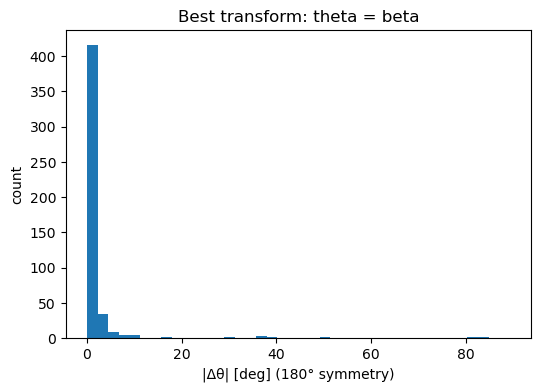

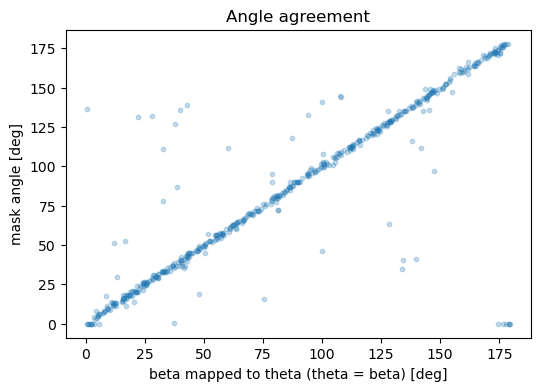

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mask_angle_deg(mask_bool: np.ndarray):
    """
    Estimate trail orientation from a boolean mask using second moments.
    Returns angle in degrees in IMAGE coordinates where:
      x increases to the right (cols),
      y increases downward (rows),
      angle is measured CCW from +x (to the right) toward +y (down).
    """
    ys, xs = np.nonzero(mask_bool)
    if len(xs) < 30:
        return np.nan
    x = xs.astype(float)
    y = ys.astype(float)
    x -= x.mean()
    y -= y.mean()
    # covariance
    Sxx = np.mean(x*x)
    Syy = np.mean(y*y)
    Sxy = np.mean(x*y)
    # principal axis angle
    theta = 0.5 * np.arctan2(2*Sxy, (Sxx - Syy))
    return float(np.degrees(theta) % 180.0)  # 180-deg symmetry

def ang_diff_180(a, b):
    """Smallest absolute difference between angles a,b with 180-deg symmetry."""
    d = (a - b) % 180.0
    d = np.minimum(d, 180.0 - d)
    return d

# ---- sample rows (use your `d` dataframe and `masks` array from H5) ----
ss = d.sample(n=min(500, len(d)), random_state=0).copy()

angles = []
for _, row in ss.iterrows():
    img_id = int(row["image_id"])
    m = masks[img_id].astype(bool)
    # cutout around (x,y) so mask-angle is local
    m_s, _, _ = cutout(m, float(row["x"]), float(row["y"]), half=96)
    th_mask = mask_angle_deg(m_s)
    if not np.isfinite(th_mask):
        continue
    beta = float(row["beta"])
    angles.append((th_mask, beta))

angles = np.asarray(angles, float)
th_mask = angles[:,0]
beta = angles[:,1]

# Candidate transforms from your beta -> image theta (deg CCW from +x toward +y-down)
# (These cover the typical "PA east of north" vs "image x/y" ambiguity and y-flip.)
candidates = {
    "theta = beta":              beta % 180.0,
    "theta = -beta":             (-beta) % 180.0,
    "theta = 90 - beta":         (90.0 - beta) % 180.0,
    "theta = beta - 90":         (beta - 90.0) % 180.0,
    "theta = 90 + beta":         (90.0 + beta) % 180.0,
    "theta = 270 - beta":        (270.0 - beta) % 180.0,
}

stats = []
for name, th_pred in candidates.items():
    dth = ang_diff_180(th_mask, th_pred)
    stats.append((name, np.median(dth), np.median(np.abs(dth - np.median(dth)))))
stats = sorted(stats, key=lambda x: x[1])

print("Angle convention test (lower median is better):")
for name, med, mad in stats:
    print(f"{name:20s}  median|Δθ|={med:6.2f} deg   MAD={mad:6.2f} deg")

best_name = stats[0][0]
best_theta = candidates[best_name]
dth_best = ang_diff_180(th_mask, best_theta)

plt.figure(figsize=(6,4))
plt.hist(dth_best, bins=40)
plt.xlabel("|Δθ| [deg] (180° symmetry)")
plt.ylabel("count")
plt.title(f"Best transform: {best_name}")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(best_theta, th_mask, s=10, alpha=0.25)
plt.xlabel(f"beta mapped to theta ({best_name}) [deg]")
plt.ylabel("mask angle [deg]")
plt.title("Angle agreement")
plt.show()


N used: 500
Median(L_msk / L_cat): 1.3488506999630399
MAD ratio: 0.1770393128306187


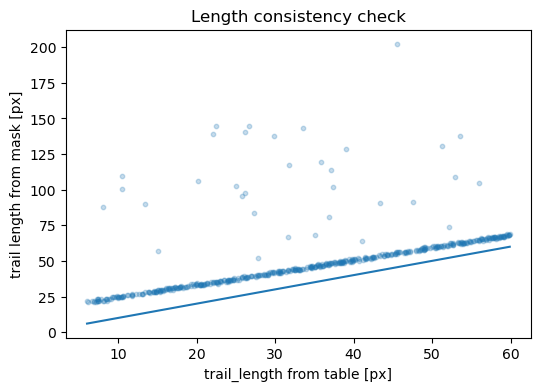

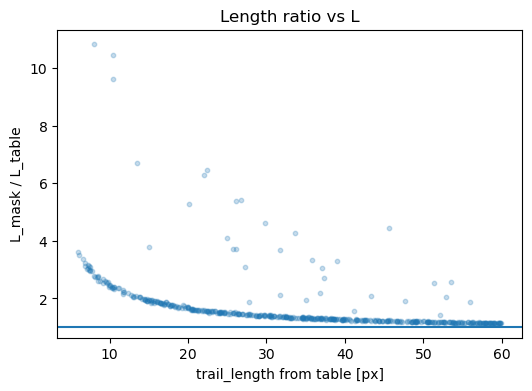

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def mask_length_px(mask_bool: np.ndarray):
    """
    Estimate trail length in px from mask by projecting points onto principal axis
    and taking robust extent (percentile range).
    """
    ys, xs = np.nonzero(mask_bool)
    if len(xs) < 30:
        return np.nan

    x = xs.astype(float)
    y = ys.astype(float)
    x0 = x.mean()
    y0 = y.mean()
    x -= x0
    y -= y0

    # principal axis via covariance
    Sxx = np.mean(x*x)
    Syy = np.mean(y*y)
    Sxy = np.mean(x*y)
    theta = 0.5 * np.arctan2(2*Sxy, (Sxx - Syy))

    ux = np.cos(theta)
    uy = np.sin(theta)

    s = x*ux + y*uy  # projection onto axis
    # robust extent: 5–95% (avoids fat ends/thickness artifacts)
    lo, hi = np.percentile(s, [5, 95])
    return float(hi - lo)

ss = d.sample(n=min(500, len(d)), random_state=1).copy()

L_cat = []
L_msk = []

for _, row in ss.iterrows():
    img_id = int(row["image_id"])
    m = masks[img_id].astype(bool)
    m_s, _, _ = cutout(m, float(row["x"]), float(row["y"]), half=96)
    lm = mask_length_px(m_s)
    if not np.isfinite(lm):
        continue
    L_cat.append(float(row["trail_length"]))
    L_msk.append(lm)

L_cat = np.asarray(L_cat)
L_msk = np.asarray(L_msk)

print("N used:", len(L_cat))
print("Median(L_msk / L_cat):", np.median(L_msk / L_cat))
print("MAD ratio:", np.median(np.abs((L_msk/L_cat) - np.median(L_msk/L_cat))))

plt.figure(figsize=(6,4))
plt.scatter(L_cat, L_msk, s=10, alpha=0.25)
plt.plot([L_cat.min(), L_cat.max()], [L_cat.min(), L_cat.max()])
plt.xlabel("trail_length from table [px]")
plt.ylabel("trail length from mask [px]")
plt.title("Length consistency check")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(L_cat, L_msk/L_cat, s=10, alpha=0.25)
plt.axhline(1.0)
plt.xlabel("trail_length from table [px]")
plt.ylabel("L_mask / L_table")
plt.title("Length ratio vs L")
plt.show()


In [55]:
# Cell 1 — utilities: mask-length estimator + binned median + safe helpers
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def binned_median(x, y, bins):
    x = np.asarray(x); y = np.asarray(y)
    out = []
    for i in range(len(bins)-1):
        m = (x >= bins[i]) & (x < bins[i+1]) & np.isfinite(y) & np.isfinite(x)
        if np.any(m):
            out.append(((bins[i]+bins[i+1])/2.0, np.median(y[m]), np.sum(m)))
    return np.asarray(out, float)

def mask_length_from_stamp(mask_stamp: np.ndarray, *, qlo=0.05, qhi=0.95, min_pix=30):
    """
    Estimate trail length in pixels from a binary mask stamp via PCA projection.
    Returns:
      L_mask (float), theta_deg (float), centroid (cx,cy), n_pix (int)
    theta_deg is CCW from +x axis (image column axis), in degrees.
    """
    m = mask_stamp.astype(bool)
    ys, xs = np.nonzero(m)
    n = len(xs)
    if n < min_pix:
        return np.nan, np.nan, (np.nan, np.nan), n

    x = xs.astype(np.float64)
    y = ys.astype(np.float64)
    cx = x.mean(); cy = y.mean()
    X = np.stack([x - cx, y - cy], axis=1)

    # PCA direction (largest eigenvector of covariance)
    C = (X.T @ X) / max(n - 1, 1)
    w, V = np.linalg.eigh(C)
    v = V[:, np.argmax(w)]              # principal axis unit vector (not yet normalized)
    v = v / np.linalg.norm(v)

    # project points onto axis
    t = X @ v
    lo = np.quantile(t, qlo)
    hi = np.quantile(t, qhi)
    L = float(hi - lo)

    theta = float(np.degrees(np.arctan2(v[1], v[0])))  # deg, CCW from +x
    return L, theta, (float(cx), float(cy)), n

def cutout_bool(arr_bool, x, y, half=96):
    """
    Cut out a (2*half+1)^2 stamp centered at integer-rounded (x,y).
    Returns: stamp, x0, y0
    """
    H, W = arr_bool.shape
    cx = int(round(float(x)))
    cy = int(round(float(y)))
    x0 = cx - half
    y0 = cy - half
    x1 = x0 + 2*half + 1
    y1 = y0 + 2*half + 1

    stamp = np.zeros((2*half+1, 2*half+1), dtype=bool)

    ix0 = max(0, x0); iy0 = max(0, y0)
    ix1 = min(W, x1); iy1 = min(H, y1)

    if ix0 < ix1 and iy0 < iy1:
        sx0 = ix0 - x0; sy0 = iy0 - y0
        sx1 = sx0 + (ix1 - ix0); sy1 = sy0 + (iy1 - iy0)
        stamp[sy0:sy1, sx0:sx1] = arr_bool[iy0:iy1, ix0:ix1]

    return stamp, x0, y0


Counts: {} | used: 2000
Median(L_mask/L_table): 1.3549482384607363  MAD: 0.17593252718963925


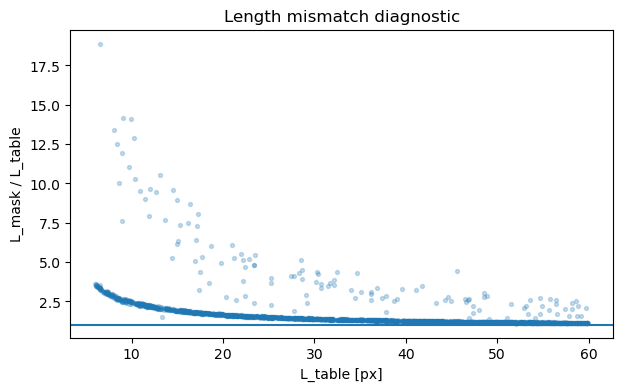


Binned medians:
L~   9.89  r~   2.455   n=212
L~  16.49  r~   1.839   n=234
L~  23.09  r~   1.554   n=249
L~  29.69  r~   1.403   n=253
L~  36.30  r~   1.306   n=251
L~  42.90  r~   1.238   n=272
L~  49.50  r~   1.190   n=244
L~  56.10  r~   1.154   n=245


In [56]:
# Cell 2 — build L_mask and diagnose L_mask / L_table trend on a sample
# Assumes you already have: d (DataFrame), masks (H5 masks array), get_calexp_for_row(row) for later
# Only uses masks here (cheap). Increase N if you want.
N = min(2000, len(d))
ssL = d.sample(n=N, random_state=123).copy()

why = Counter()
L_table = []
L_mask  = []
img_ids = []
for _, row in ssL.iterrows():
    try:
        img_id = int(row["image_id"])
        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"])
    except Exception:
        why["row_parse_fail"] += 1
        continue

    try:
        m = masks[img_id].astype(bool)
        stamp, _, _ = cutout_bool(m, x0, y0, half=96)
        Lm, theta_m, (cx,cy), n = mask_length_from_stamp(stamp, qlo=0.05, qhi=0.95, min_pix=30)
        if not np.isfinite(Lm) or Lm <= 0:
            why["mask_len_nan"] += 1
            continue
    except Exception:
        why["mask_fail"] += 1
        continue

    L_table.append(L)
    L_mask.append(Lm)
    img_ids.append(img_id)

L_table = np.asarray(L_table, float)
L_mask  = np.asarray(L_mask, float)
ratio_L = L_mask / L_table

print("Counts:", dict(why), "| used:", len(L_table))
print("Median(L_mask/L_table):", np.median(ratio_L), " MAD:", np.median(np.abs(ratio_L - np.median(ratio_L))))

plt.figure(figsize=(7,4))
plt.scatter(L_table, ratio_L, s=8, alpha=0.25)
plt.axhline(1.0)
plt.xlabel("L_table [px]")
plt.ylabel("L_mask / L_table")
plt.title("Length mismatch diagnostic")
plt.show()

# Build a binned mapping r(L) = median(L_mask/L_table) and an interpolator
bins = np.linspace(np.percentile(L_table, 1), np.percentile(L_table, 99), 9)
bm = binned_median(L_table, ratio_L, bins)
print("\nBinned medians:")
for xc, med, n in bm:
    print(f"L~ {xc:6.2f}  r~ {med:7.3f}   n={int(n)}")

# simple piecewise-linear interpolator for r(L)
bx = bm[:,0].copy()
by = bm[:,1].copy()

def r_of_L(L):
    L = np.asarray(L, float)
    return np.interp(L, bx, by, left=by[0], right=by[-1])


Counts: {'sigmaF_nonfinite': 1} | used: 299

Median ratio stack/model:
  raw L:     3.74460040384465
  mapped L:  5.1821542437805626
  mask L:    5.231201439860674


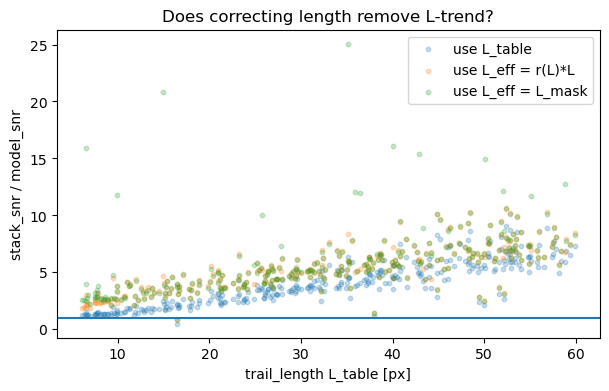

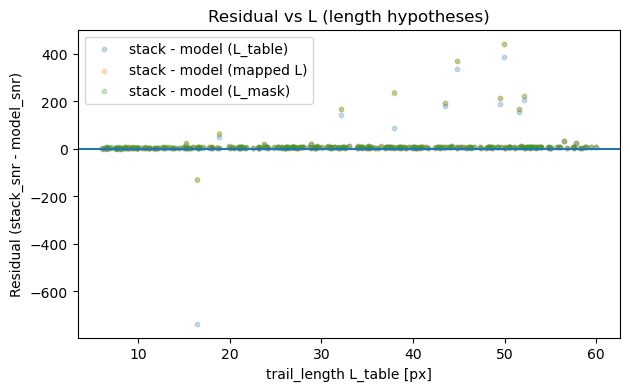

In [57]:
# Cell 3 — test if using L_eff fixes stack/model trend
# This is the expensive part: butler I/O + sigmaF. Start with ~150–300 rows.
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def model_snr_from_mag(calexp, mag, sigmaF):
    F = float(calexp.getPhotoCalib().magnitudeToInstFlux(float(mag)))
    return F / float(sigmaF)

M = min(300, len(d))
ss = d.sample(n=M, random_state=7).copy()

why = Counter()
rows = []

for _, row in ss.iterrows():
    try:
        calexp, _ = get_calexp_for_row(row)

        x0 = float(row["x"]); y0 = float(row["y"])
        L  = float(row["trail_length"]); th = float(row["beta"])
        stack_snr = float(row["stack_snr"])
        psf_mag   = float(row["stack_mag"]) if "stack_mag" in row else float(row["PSF_mag"])  # fallback

        # L_mask from mask stamp
        img_id = int(row["image_id"])
        m = masks[img_id].astype(bool)
        stamp, _, _ = cutout_bool(m, x0, y0, half=96)
        Lm, _, _, n = mask_length_from_stamp(stamp, qlo=0.05, qhi=0.95, min_pix=30)
        if not np.isfinite(Lm) or Lm <= 0:
            why["Lmask_bad"] += 1
            continue

        # three length hypotheses
        L_eff_mask = float(Lm)
        L_eff_map  = float(L * r_of_L(L))   # smooth mapping from Cell 2 (median ratio vs L)
        L_eff_raw  = float(L)

        # compute sigmaF for each hypothesis (same theta)
        s_raw  = psf_fit_flux_sigma(calexp, x0, y0, L_pix=L_eff_raw,  theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15)
        s_map  = psf_fit_flux_sigma(calexp, x0, y0, L_pix=L_eff_map,  theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15)
        s_mask = psf_fit_flux_sigma(calexp, x0, y0, L_pix=L_eff_mask, theta_deg=th, use_kernel_image=True, pad_sigma=5.0, step=0.15)

        if not (np.isfinite(s_raw) and np.isfinite(s_map) and np.isfinite(s_mask)):
            why["sigmaF_nonfinite"] += 1
            continue

        # Predict stack SNR from PSF magnitude (since stack_snr is consistent with mag_err)
        snr_raw  = model_snr_from_mag(calexp, psf_mag, s_raw)
        snr_map  = model_snr_from_mag(calexp, psf_mag, s_map)
        snr_mask = model_snr_from_mag(calexp, psf_mag, s_mask)

        rows.append((L, L_eff_map, L_eff_mask, stack_snr, snr_raw, snr_map, snr_mask))

    except Exception:
        why["exception"] += 1
        continue

print("Counts:", dict(why), "| used:", len(rows))
rows = np.asarray(rows, float)
if len(rows) == 0:
    raise RuntimeError("No rows survived. Check 'Counts' above.")

L0      = rows[:,0]
Leffmap = rows[:,1]
Leffmsk = rows[:,2]
stack   = rows[:,3]
snr_raw = rows[:,4]
snr_map = rows[:,5]
snr_msk = rows[:,6]

# Compare ratios (stack/model)
rat_raw = stack / snr_raw
rat_map = stack / snr_map
rat_msk = stack / snr_msk

print("\nMedian ratio stack/model:")
print("  raw L:    ", np.median(rat_raw))
print("  mapped L: ", np.median(rat_map))
print("  mask L:   ", np.median(rat_msk))

plt.figure(figsize=(7,4))
plt.scatter(L0, rat_raw, s=10, alpha=0.25, label="use L_table")
plt.scatter(L0, rat_map, s=10, alpha=0.25, label="use L_eff = r(L)*L")
plt.scatter(L0, rat_msk, s=10, alpha=0.25, label="use L_eff = L_mask")
plt.axhline(1.0)
plt.xlabel("trail_length L_table [px]")
plt.ylabel("stack_snr / model_snr")
plt.legend()
plt.title("Does correcting length remove L-trend?")
plt.show()

# Residuals
res_raw = stack - snr_raw
res_map = stack - snr_map
res_msk = stack - snr_msk

plt.figure(figsize=(7,4))
plt.scatter(L0, res_raw, s=10, alpha=0.25, label="stack - model (L_table)")
plt.scatter(L0, res_map, s=10, alpha=0.25, label="stack - model (mapped L)")
plt.scatter(L0, res_msk, s=10, alpha=0.25, label="stack - model (L_mask)")
plt.axhline(0.0)
plt.xlabel("trail_length L_table [px]")
plt.ylabel("Residual (stack_snr - model_snr)")
plt.legend()
plt.title("Residual vs L (length hypotheses)")
plt.show()


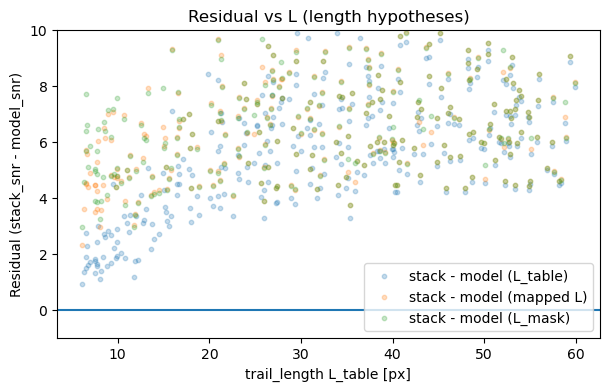

In [59]:
plt.figure(figsize=(7,4))
plt.scatter(L0, res_raw, s=10, alpha=0.25, label="stack - model (L_table)")
plt.scatter(L0, res_map, s=10, alpha=0.25, label="stack - model (mapped L)")
plt.scatter(L0, res_msk, s=10, alpha=0.25, label="stack - model (L_mask)")
plt.axhline(0.0)
plt.xlabel("trail_length L_table [px]")
plt.ylabel("Residual (stack_snr - model_snr)")
plt.legend()
plt.ylim(-1, 10)
plt.title("Residual vs L (length hypotheses)")
plt.show()